$\setcounter{secnumdepth}{0}$

## Completed by:   
*   Denys Botuk

In [1]:
import time
import math
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.diagnostic as dgn
from scipy.optimize import curve_fit
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, mean_squared_error, confusion_matrix, roc_curve, auc, accuracy_score
from scikitplot.metrics import plot_roc
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor
from sklearn.model_selection import train_test_split
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)

# Problem 5: Linear regression

## _In this assignment we will deal with tools and methods for visualizing data and computing some simple characteristic measures. Our aim here is to apply all the basic techniques and to draw correct conclusions. The data we work with is the Ames Housing data set available for download at Kaggle: https://www.kaggle.com/c/house-prices-advanced-regression-techniques/overview or included into the AmesHousing package in R. Note that the kaggle and R data sets differ slightly. Thus it is better not to mix results from kaggle/Python and R. The overall objective is to explain the sale prices SalePrice._

In [2]:
house_data = pd.read_csv('house-prices-advanced-regression-techniques/train.csv', index_col=0)
house_data

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500


## _1. Before fitting a model to the data, first we have a closer look at the definitions of the variables and decide if some of them might require a separate treatment. Consider, for example, the first variable MSSubClass. It takes textual values and obviously cannot be included into the linear model as it is. There are two approaches how this can be handled. One approach is to assign numbers from 1 to 16 to each possible outcome. Another approach is to create new dummy variables that are equal one for a specific outcome and zero else. Discuss these two approaches and suggest which approach is more appropriate here. Motivate your decision and keep in mind the nominal, ordinal, and cardinal scales from Statistics. Run a simple regression of SalePrices on MSSubClass taken as it is (without creating dummies or 1,...,16 variable). Check how does your software handle this type of a variable. (In R your data must be stored as a data frame.)_

Let's look at the variable 'MSSubClass'. Let's get a list of its unique values.

In [3]:
house_data['MSSubClass'].unique()

array([ 60,  20,  70,  50, 190,  45,  90, 120,  30,  85,  80, 160,  75,
       180,  40])

So, this column contains 15 different integer values. We can suppose, that it is a categorical variable with some order (ordinal variable), but if we look into data_description.txt file we can see, that it is just a set of ids (16 possible, '150' is not present), that identifies the type of dwelling. Thus, each of dwelling type is not comparable, then it is a nominal variable.

To handle nominal variables creation of dummy variables approach would be better to use, as its values could not be ordered. Such approach has some drawbacks: a huge amount of dummy variables can lead to higher memory usage and more computations. Also it can significantly increase the complexity of the model. This can lead to overfitting, especially if the dataset isn't large enough to support these features. Another drawback is the risk of multicollinearity, especially if one category is predictable from a combination of others.

In our case we should create 15 dummy variables, that is not significantly large for dummy variable creation.

The second approach is to assign numbers from 1 to 15 to each possible outcome. It would be great for the case of ordinal variables, even more, we already have integer values, if it was comparable, we would leave it as it is.

So, currently, as its values are just ids of dwelling type (not comparable), then dummy variable creation approach would be the best.

Now, let's try to run simple ordinary least squares regression (OLS) and look at the results.

In [4]:
model = smf.ols(formula="SalePrice ~ C(MSSubClass)", data=house_data).fit()
model.params

Intercept               185224.811567
C(MSSubClass)[T.30]     -89395.086929
C(MSSubClass)[T.40]     -29099.811567
C(MSSubClass)[T.45]     -76633.144900
C(MSSubClass)[T.50]     -41921.839345
C(MSSubClass)[T.60]      54723.690105
C(MSSubClass)[T.70]     -18452.394900
C(MSSubClass)[T.75]       7212.688433
C(MSSubClass)[T.80]     -15488.259843
C(MSSubClass)[T.85]     -37414.811567
C(MSSubClass)[T.90]     -51683.734644
C(MSSubClass)[T.120]     15554.268893
C(MSSubClass)[T.160]    -46577.430615
C(MSSubClass)[T.180]    -82924.811567
C(MSSubClass)[T.190]    -55611.478234
dtype: float64

So, as we concluded the best approach is to create dummy variables and we got the same result by software, it splitted 'MSSubClass' variable into new 15 ones and linear regression model has found separate coefficients for each category.

## _2. Consider the following numeric explanatory variables LotFrontage, LotArea, YearBuilt, BsmtFinSF1, BsmtUnfSF. Plot the scatter plot of SalePrices vs. these variables. Analyse every plot and discuss the potential problems/transformations/extentions of the model to take the patterns into account. Remember, that you can either transform variables or create new variables to capture non-standard patterns._

Now let's analyse the dependence between 'SalePrice' and 'LotFrontage', 'LotArea', 'YearBuilt', 'BsmtFinSF1', 'BsmtUnfSF' variables, plotting its paired scatterplots.

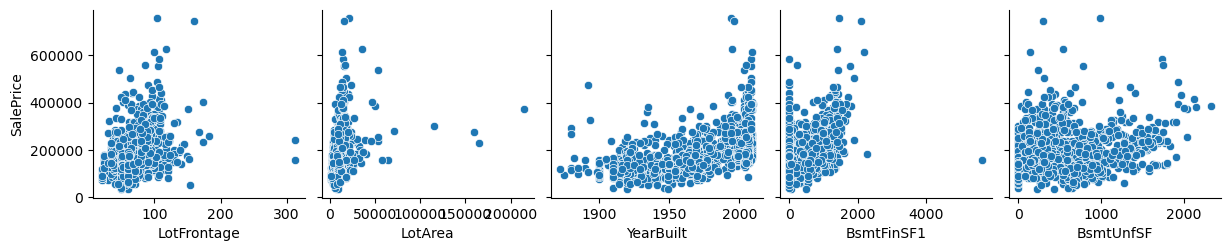

In [5]:
sns.pairplot(house_data, 
             x_vars=['LotFrontage','LotArea','YearBuilt','BsmtFinSF1','BsmtUnfSF'],
             y_vars=['SalePrice'])
plt.show()

Then observe each scatter plot:

_'LotFrontage' vs 'SalePrice':_

Here we can notice that most of the relationship is not strictly linear. Observations are concentrated in some range $(0, 150)$. Moreover, relationship is positive (the more $LotFrontage$ is the more $SalePrice$ is). Simultaneously, we can notice some outliers for $LotFrontage$ near $300$. To take its pattern into account, it would be better to transform $LotFrontage$ into $LotFrontage^2$ or $\log(LotFrontage)$

_'LotArea' vs 'SalePrice':_

The relationship is also not strictly linear here. It is positive (the more $LotArea$ is the more $SalePrice$ is). Moreover, there are some outliers for large values of $LotArea$. An appropriate transformation of $LotArea$ to decrease an impact of outliers will be into $\sqrt{LotArea}$ or $\log(LotArea)$.

_'YearBuilt' vs 'SalePrice':_

The relationship between $YearBuilt$ and $SalePrice$ is the most linear of the ones, represented by the scatterplots above. The outliers here are no significant. The one transformation, which could be useful here, is $YearBuilt^2$.

_'BsmtFinSF1' vs 'SalePrice':_

The relationship is also not strictly linear. It is positive (the more $BsmtFinSF1$ is the more $SalePrice$ is).  There are some significant outliers for large values of $BsmtFinSF1$. If we remove the outliers, then transformation $BsmtFinSF1^2$ will provide a good representation of data. If we don't remove it, then transformation $\log(BsmtFinSF1)$ will decrease an impact of outliers.

_'BsmtUnfSF' vs 'SalePrice':_

Here we can also notice that most of the relationship is not strictly linear. Observations are concentrated in some range lower range of $SalePrice$. The relationship is also positive (the more $BsmtUnfSF$ is the more $SalePrice$ is). There are some outliers for large values of $SalePrice$. To take its pattern into account, it would be better to transform $BsmtUnfSF$ into $BsmtUnfSF^2$.

In [6]:
def transform(regressor):
    if regressor == 'LotFrontage':
        return lambda x: 100000 * np.log(x - 20) - 100000
    elif regressor == 'LotArea':
        return lambda x: 100000 * np.log(x) - 700000
    elif regressor == 'YearBuilt':
        return lambda x: 20 * (x - 1900)**2 + 100000
    elif regressor == 'BsmtFinSF1':
        return lambda x: 0.2 * x**2 + 100000
    elif regressor == 'BsmtUnfSF':
        return lambda x: 0.1 * x**2 + 150000
    else:
        return lambda x: x

Now, let's plot one transformation function from suggested above per each scatter plot.

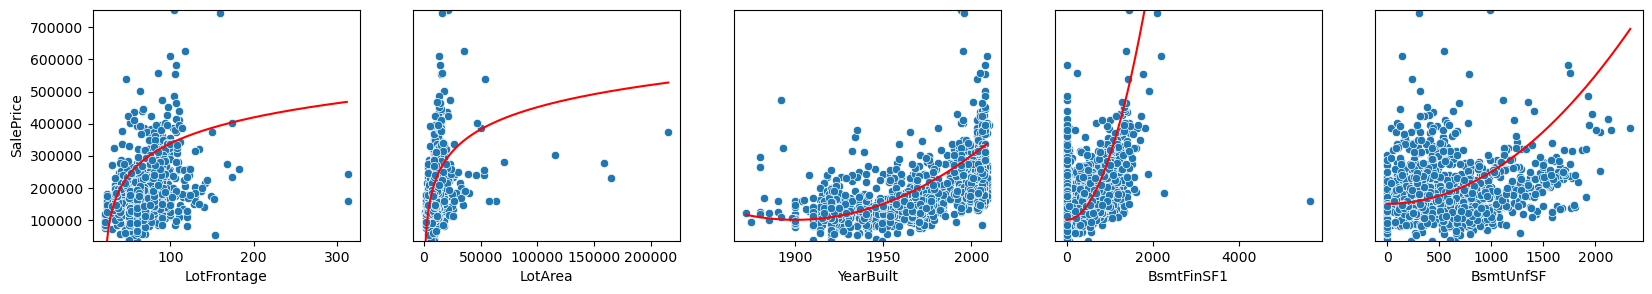

In [7]:
regressors = ['LotFrontage', 'LotArea', 'YearBuilt', 'BsmtFinSF1', 'BsmtUnfSF']

plt.figure(figsize=(20, 3))

for i in range(len(regressors)):
    plt.subplot(1, 5, i+1);
    x_cords = np.arange(np.min(house_data[regressors[i]]),np.max(house_data[regressors[i]]))
    y_cords = transform(regressors[i])(x_cords)
    if i > 0:
        plt.yticks([])
    plt.ylim(np.min(house_data['SalePrice']),np.max(house_data['SalePrice']))
    plt.plot(x_cords, y_cords, color='red')
    sns.scatterplot(x=regressors[i], y='SalePrice', data=house_data)

plt.show()

To see how we improved our model, let's compare STD error for each data with STD error of transformed ones.

In [8]:
for i in range(len(regressors)):
    filtered_data = house_data.dropna(subset=[regressors[i], 'SalePrice'])
    
    X = filtered_data[regressors[i]]
    X = sm.add_constant(X)
    X_transformed = filtered_data[regressors[i]].transform(transform(regressors[i]))
    
    y = filtered_data['SalePrice']
    
    model = sm.OLS(y, X).fit()
    model_transformed = sm.OLS(y, X_transformed).fit()
    
    print(f"===========\t'{regressors[i]}' vs 'SalePrice'\t===========")
    print(f"STD error for X:\t\t{model.bse[regressors[i]]}")
    print(f"STD error transformed X:\t{model_transformed.bse[regressors[i]]}")
    print()

===========	'LotFrontage' vs 'SalePrice'	===========
STD error for X:		92.82802380657984
STD error transformed X:	0.008404851318716442

===========	'LotArea' vs 'SalePrice'	===========
STD error for X:		0.2010575176984749
STD error transformed X:	0.008955062215361829

===========	'YearBuilt' vs 'SalePrice'	===========
STD error for X:		58.71738268911011
STD error transformed X:	0.007541594689170842

===========	'BsmtFinSF1' vs 'SalePrice'	===========
STD error for X:		4.207256065345162
STD error transformed X:	0.0137044039912459

===========	'BsmtUnfSF' vs 'SalePrice'	===========
STD error for X:		4.598927111832797
STD error transformed X:	0.01073596928622214



So, as a result we can notice that due to transformation STD error decreased to at least $0.01$ per each regressor.

## _3. Fit a simple linear regression without making the transformations discussed above. Pick up one of the numeric regressors, for example, LotArea. Write down the corresponding hypothesis of the t-test. Provide the formula for the test statistics, explain the components of the formula and give the values for these components. Assess the goodness-of-fit of the model. Explain in your own words the difference between $R^2$ and adjusted $R^2$._

Now, let's try to run a simple linear regression with 'LotArea' as regressor and 'SalePrice' as regressand.

The simplest one is a linear regression with coefficients $\beta_0$ and $\beta_1$:
$$y_i = \beta_0 + \beta_1 x_i, \qquad i=1, \dots, N$$
and ordinary least squares estimator (OLS):
$$y_i = \beta_0 + \beta_1 x_i + u_i, \qquad i=1, \dots, N$$
$$\sum\limits_{i=1}^N u_i^2 = \sum\limits_{i=1}^N [y_i - (\beta_0 + \beta_1 x_i)]^2 \rightarrow min \qquad w.r.t. \beta_0, \beta_1$$
We can test, if the coefficients deviate from a given value, using $t$-test:
$$H_0: \beta_j = \beta_j^* \qquad vs \qquad H_1: \beta_j \neq \beta_j^*$$
Then test statistics will be:
$$t_{emp} = \frac{\hat{\beta_j} - \beta_j^*}{\sqrt{\hat{Var(\hat{\beta_j})}}}$$
where:
- $\hat{\beta_j}$ is estimation of $\beta_j$, $\hat{\beta}_{j,OLS}$ is $j$ element of $(X^\top X)^{-1}X^\top y$
- $\beta_j^*$ is a target value
- $\hat{Var(\hat{\beta_j})}$ is the value of $j$ element on a diagonal of $\hat{\sigma}^2(X^\top X)^{-1}$, $\hat{\sigma}^2 = \frac{\hat{u}^\top \hat{u}}{N-K-1}$
- $t_{emp} \sim t_{N-K-1}$, $N$ - number of observations, $K$ - number of $\beta_j$ ($K = 2$ in our case)

The rejection area will be equal to $B = (-\infty; -t_{N-K-1;1-\frac{\alpha}{2}}) \cup (t_{N-K-1;1-\frac{\alpha}{2}}; +\infty)$

So, now let's run a linear regression to find the values of $\beta_j$, estimated by OLS:

In [9]:
X = house_data['LotArea']
X = sm.add_constant(X)
y = house_data['SalePrice']
    
model = sm.OLS(y, X).fit()
beta_OLS = model.params
beta_OLS

const      158836.151897
LotArea         2.099972
dtype: float64

The most common test is the test with $\beta^*_j = 0$. If we can't reject null hypothesis, then we can conclude that $\beta_j$ is significant.

In [10]:
beta_star = np.zeros_like(beta_OLS)
beta_star

array([0., 0.])

The to find test-statistics we need to find the value of $\hat{Var(\hat{\beta_j})}$:

In [11]:
sigma_squared = (y - X @ beta_OLS).T @ (y - X @ beta_OLS) / (len(y) - 3)
var = np.diag(sigma_squared * np.linalg.inv(X.T @ X))
var

array([8.50140896e+06, 4.04518702e-02])

Then test statistics for $\beta_j$ will be equal to:

In [12]:
t = (beta_OLS - beta_star) / np.sqrt(var)
t

const      54.475836
LotArea    10.441050
dtype: float64

To draw a conclusions, let's find $t_{N-K-1;1-\frac{\alpha}{2}}$ for $\alpha = 0.05$:

In [13]:
alpha = 0.05
st.t.ppf(1 - alpha/2, len(y) - 3)

1.9615935038492915

So, rejection area is $B = (-\infty;-1.9615) \cup (1.9615;+\infty)$. Any of $t_{emp,j}$ is not in the rejection area, so both $\beta_0$ and $\beta_1$ are significant.

To asses the goodness-of-it of the model we can use the adjusted coefficient of determination $R^2$:
$$R^2 = 1 - \frac{\sum\limits_{i=1}^N (y_i - \hat{y_i})^2}{\sum\limits_{i=1}^N (y_i - \bar{y_i})^2}$$
With increasing of the features number $R^2$ is also increasing, then it becomes useless as it will indicate model better, when it contains more number of features. Alternatively, we can calculate $R^2_{adj}$:
$$R^2_{adj} = 1 - \frac{\frac{1}{N-K-1}\sum\limits_{i=1}^N (y_i - \hat{y_i})^2}{\frac{1}{N-1}\sum\limits_{i=1}^N (y_i - \bar{y_i})^2}$$
This coefficient penalizes addition of variables that do not improve the model significantly. Unlike $R^2$, $R^2_{adj}$ can decrease if unhelpful predictors are added to the model. This makes it a more reliable measure, especially for models with a large number of predictors or when comparing models with different numbers of predictors.

As we have only $2$ coefficients, then it actually doesn't matter, which coefficient to use. 

Let's calculate $R^2$:

In [14]:
R_squared = 1 - np.sum((y - X @ beta_OLS)**2) / np.sum((y - np.mean(y))**2)
R_squared

0.0696133153821119

As we have two coeffients $\beta_0$, $\beta_1$ ($K=2$), then $R^2$ equals the squared correlation between the observed values and the fitted values $R^2 = r_{y,\hat{y}}^2$, so $R^2$ represents the correlation between true and predicted values. In our case $R^2$ is too low ($R^2 = 0.069$), it indicates that about $6.9\%$ of the variability in the dependent variable is explained by the model. So, we can conclude a weak fit of the model to the data. Thus, the relationship is not linear.

## _4. If you wish to argue that MSSubClass is insignificant and use the model with dummies than you have to check the simultaneous insignificance of all the dummies that stem from the factor variable MSSubClass. Run a test for a general linear hypothesis and conclude about the significance of MSSubClass. Write down the matrix and the vector needed in the hypothesis._

To test if dummies, created from 'MSSubClass', considered together are significant or not, we can test the following hypothesis:
$$H_0: \beta_1 = \dots = \beta_{15} = 0$$
or reformulate this hypothesis as general linear hypothesis:
$$H_0: R\beta = r \qquad vs \qquad H_1: R\beta \neq r$$
where $R$ is $q \times K+1$ matrix with $rank(R) = q$, $r$ - vectors of size $K+1 \times 1$.

In our case $R = I_{15}$ and $r = 0_{15}$ (zero-vector of size $15\times1$.

Then test statistics will be:
$$T = \frac{(R\hat{\beta} - r)^\top(R (X^\top X)^{-1} R^\top)^{-1}(R\hat{\beta} - r)}{q \cdot \hat\sigma^2}$$
where:
- $\hat{\beta}$ is vector that contains estimation of $\beta_j$ coefficients
- $\hat{\sigma}^2 = \frac{\hat{u}^\top \hat{u}}{N-K-1}$
- $R = I_K$
- $r = 0_K$
- $T \sim F_{q, N-K-1}$, $q = rank(R)$, $N$ - number of observations, $K$ - number of $\beta_j$

The rejection area will be equal to  $B = (-\infty; -F_{q, N-K-1}) \cup (F_{q, N-K-1}; +\infty)$

So, now let's run a linear regression to find the values of $\beta$, estimated by OLS:

In [15]:
X = pd.get_dummies(house_data['MSSubClass'], dtype=float)
y = np.array(house_data['SalePrice'])

model = sm.OLS(y, X).fit()
beta_OLS = model.params
beta_OLS

20     185224.811567
30      95829.724638
40     156125.000000
45     108591.666667
50     143302.972222
60     239948.501672
70     166772.416667
75     192437.500000
80     169736.551724
85     147810.000000
90     133541.076923
120    200779.080460
160    138647.380952
180    102300.000000
190    129613.333333
dtype: float64

Then, form matrix $R = I_K$:

In [16]:
R = np.eye(len(beta_OLS))
R

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0.

and vector $r = 0_K$:

In [17]:
r = np.zeros(len(beta_OLS))
r

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

Finally, let's calculate test statistics $T$:

In [18]:
T = ((R @ beta_OLS - r).T @ np.linalg.inv(R @ np.linalg.inv(X.T @ X) @ R.T) @ (R @ beta_OLS - r)) / (((y - X @ beta_OLS).T @ (y - X @ beta_OLS) / (len(y) - len(beta_OLS) - 1)) * len(beta_OLS))
T

694.3755728874185

To draw a conclusions, let's find $F_{q;N-K-1;1-\frac{\alpha}{2}}$ for $\alpha = 0.05$:

In [19]:
st.f.ppf(1 - alpha/2, len(beta_OLS), len(y) - len(beta_OLS) - 1)

1.8417650316724925

So, rejection area is $B = (-\infty;-1.8417) \cup (1.8417;+\infty)$. As $T$ is in the rejection area, so we reject null hypothesis and then we conclude that dummy variables of 'MSSubClass', considered together, have significant impact on SalePrice.

## _5. Give economic interpretation for the parameters of LotArea, first dummy for MSSubClass (it is a tricky question!), and BedroomAbvGr. (Ignore the potential insignificance.) How would the interpretations change if you model log of SalePrices?_

To give economic interpretation for the parameters, let's find its values first.

So, let's form matrix of regressors $X$:

In [20]:
X = house_data[['LotArea', 'BedroomAbvGr']] 

first_mssubclass_dummy = pd.get_dummies(house_data['MSSubClass'], prefix='MSSubClass').iloc[:,0].astype(int)
X = pd.concat([X, first_mssubclass_dummy], axis=1)
X = sm.add_constant(X)

X

,const,LotArea,BedroomAbvGr,MSSubClass_20
Id,,,,
1,1.0,8450,3,0
2,1.0,9600,3,1
3,1.0,11250,3,0
4,1.0,9550,3,0
5,1.0,14260,4,0
...,...,...,...,...
1456,1.0,7917,3,0
1457,1.0,13175,3,1
1458,1.0,9042,4,0


and regressand $y$ will be:

In [21]:
y = house_data['SalePrice'] 
y

Id
1       208500
2       181500
3       223500
4       140000
5       250000
         ...  
1456    175000
1457    210000
1458    266500
1459    142125
1460    147500
Name: SalePrice, Length: 1460, dtype: int64

Then train our model and get estimated coefficients:

In [22]:
model = sm.OLS(y, X).fit()
beta_OLS = model.params
beta_OLS

const            118249.675115
LotArea               1.935680
BedroomAbvGr      13993.693328
MSSubClass_20      5998.646380
dtype: float64

Given these values of each parameter we can provide the following economic interpretation:

If we choose a house with a 'LotArea', higher by $1$ square foot, and 'MSSubClass' and 'BedroomAbvGr' are the same, then 'SalePrice' will be increased on average by $1.93$.

If we choose a house, which corresponds to the category of "1-STORY 1946 & NEWER ALL STYLES", and 'LotArea' and 'BedroomAbvGr' are the same, then 'SalePrice' will be higher on average on $5998.64$, than if we choose a house, which corresponds to any other category.

If we choose a house, then a 'SalePrice' will be higher on average on $13993.69$ for each additional bedroom above grade, when 'LotArea' and 'MSSubClass' remains the same.

Now let's look, what will change if we model a log of 'SalePrice'

In [23]:
model = sm.OLS(np.log(y), X).fit()
beta_OLS = model.params
beta_OLS

const            11.645241
LotArea           0.000009
BedroomAbvGr      0.092437
MSSubClass_20     0.047175
dtype: float64

Here we have the following interpretation:

With increasing of 'LotArea' by 1 square foot and remaining 'MSSubClass' and 'BedroomAbvGr' as it is 'SalePrice' will be increased on average by $0.0009\%$.

With switching to the category of "1-STORY 1946 & NEWER ALL STYLES" from any other category and remaining of 'LotArea' and 'BedroomAbvGr' values as they are 'SalePrice' increases on average on $4.71\%$.

With increasing of the bedroom number above the grade by $1$ a 'SalePrice' will increase on average on $9.24\%$, when 'LotArea' and 'MSSubClass' remains the same.

## _6. Compute the 95% confidence interval for the parameter of LotArea and provide its economic meaning. Relate the CIs to the tests of significance, i.e. how would you use these intervals to decide about the significance of the corresponding explanatory variables? The CIs are computed relying on the assumption, that the residuals follow normal distribution. Is this assumption fulfilled? Run an appropriate goodness-of-fit test._

The formula for computation of confidence interval for parameter $\beta_j$ is:
$$\beta_j \in \left[ \hat\beta_j - t_{N-K-1; \frac{1 - \alpha}{2}} \cdot \sqrt{\hat{Var(\hat\beta_j)}}; \qquad \hat\beta_j + t_{N-K-1; \frac{1 - \alpha}{2}} \cdot \sqrt{\hat{Var(\hat\beta_j)}} \right]$$
where
- $\hat{Var(\hat{\beta_j})}$ is the value of $j$ element on a diagonal of $\hat{\sigma}^2(X^\top X)^{-1}$, $\hat{\sigma}^2 = \frac{\hat{u}^\top \hat{u}}{N-K-1}$
- $N$ - number of observations, $K$ - number of $\beta_j$ ($K = 2$ in our case)

First, let's find estimated by OLS value of $\hat\beta_j$:

In [24]:
X = house_data['LotArea']
X = sm.add_constant(X)
y = house_data['SalePrice']
    
model = sm.OLS(y, X).fit()
beta_OLS = model.params
beta_OLS

const      158836.151897
LotArea         2.099972
dtype: float64

Then, let's find $\hat{Var(\hat{\beta_j})}$:

In [25]:
sigma_squared = (y - X @ beta_OLS).T @ (y - X @ beta_OLS) / (len(y) - 3)
var = np.diag(sigma_squared * np.linalg.inv(X.T @ X))
var[1]

0.040451870190006844

and $t_{N-K-1; \frac{1 - \alpha}{2}}$, where $\alpha = 0.05$:

In [26]:
alpha = 0.05
t = st.t.ppf(1 - alpha/2, len(y) - 3)
t

1.9615935038492915

So, CI for 'LotArea' parameter is:

In [27]:
beta_OLS[1] - t * np.sqrt(var[1]), beta_OLS[1] + t * np.sqrt(var[1])

(1.7054435100636085, 2.49450039335173)

So, the true impact of $1$ square foot increase of 'LotArea' on the 'SalePrice' lies between $1.70$ and $2.49$ with $95\%$ probability.

To make a conclusions about significance of the variable, we consider null hypothesis, that the corresponding parameter equals to $0$. So, in our case, we concluded that $\beta_j$, that corresponds to 'LotArea', lies in the interval between $1.70$ and $2.49$, which doesn't contain $0$. Thus, we can reject the null hypothesis that $\beta_j = 0$ with a $95\%$ level of confidence and then conclude that this parameter has significant impact on 'SalePrice'. 

In [28]:
resids = model.resid
st.kstest(resids, 'norm', args=(resids.mean(), resids.std()))

KstestResult(statistic=0.11580791274724689, pvalue=1.6266381443406534e-17, statistic_location=14414.058465315844, statistic_sign=1)

Here we have $p$-value, which is close to $0$, so it's less than $\alpha$. Thus, we reject $H_0$ that the residuals are normally distributed, so they aren't. Thus, the computation of CIs is illegal as assumption about normality is not fulfilled.

## _7. Most of the variables appear to be insignificant and we should find the smallest model that still has a good explanatory power. Choose this model using stepwise model selection (either based on the tests for $R^2$ or using $R^2_{adj}$ /AIC/BIC). Pick up the last step of the model selection procedure and explain in details how the method/approach works (or is implemented in your software). Work with this model in all the remaining steps._

Let's do some preprocessing - first remove columns with more than $50$ nan values and then remove all the rows with nan.

In [29]:
processed_house_data = house_data.dropna(axis='columns', thresh=house_data.shape[0] - 50).dropna()

According to the description of data 'ExterQual', 'ExterCond', 'HeatingQC', 'KitchenQual' are ordinal. Let's encode its values as $0, 1, \dots$

In [30]:
ordinal_variables = ['ExterQual', 'ExterCond', 'HeatingQC', 'KitchenQual']
ord_encoder = OrdinalEncoder(categories=[['Po', 'Fa', 'TA', 'Gd', 'Ex']])
for variable in ordinal_variables:
    processed_house_data[variable] = ord_encoder.fit_transform(processed_house_data[[variable]])

We can process 'Street' as binary, as it has only two values 'Pave' and 'Grvl':

In [31]:
ord_encoder = OrdinalEncoder()
processed_house_data['Street'] = ord_encoder.fit_transform(np.array(processed_house_data['Street']).reshape(-1, 1))

We can also create dummy variables for nominal parameters, but as we have a lot of them, then the size of dataframe will be significantly increased, so for now let'sjust skip them.

In [32]:
categorical_variables_to_encode = ['MSSubClass']

# categorical_variables_to_encode = list(processed_house_data.select_dtypes(include=['O']).columns)
# categorical_variables_to_encode.append('MSSubClass')

encoder = OneHotEncoder(sparse_output=False).set_output(transform="pandas")
encoded = encoder.fit_transform(processed_house_data[categorical_variables_to_encode])

processed_house_data[encoded.columns] = encoded.copy()
processed_house_data = processed_house_data.drop(columns=categorical_variables_to_encode)

# processed_house_data = processed_house_data.select_dtypes(include = ['float64', 'int64']).drop(columns=['MSSubClass'])
processed_house_data = processed_house_data.select_dtypes(include = ['float64', 'int64'])

processed_house_data

,LotArea,Street,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,ExterCond,BsmtFinSF1,...,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90,MSSubClass_120,MSSubClass_160,MSSubClass_180,MSSubClass_190
Id,,,,,,,,,,,,,,,,,,,,,
1,8450,1.0,7,5,2003,2003,196.0,3.0,2.0,706,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,9600,1.0,6,8,1976,1976,0.0,2.0,2.0,978,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,11250,1.0,7,5,2001,2002,162.0,3.0,2.0,486,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,9550,1.0,7,5,1915,1970,0.0,2.0,2.0,216,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,14260,1.0,8,5,2000,2000,350.0,3.0,2.0,655,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,7917,1.0,6,5,1999,2000,0.0,2.0,2.0,0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1457,13175,1.0,6,6,1978,1988,119.0,2.0,2.0,790,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1458,9042,1.0,7,9,1941,2006,0.0,4.0,3.0,275,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


So, we have a dataframe with $53$ columns with $6$ ordinal and $1$ nominal, decoded to dummies, variables.

Due to multicollinearity it is nor optimal simply to drop insignificant variables from the model. Therefore, stepwise model selection procedure will be better to use. According to that the variables can be added or dropped from the model sequentially. We will use a forward selection (simple-to-general) approach based on the tests for $R^2$ score.

The main steps of the method are:
0. Estimation of the model with all available variables.
1. Test the model with variable less per each variable.
2. Find the variable with the smallest and insignificant contribution to the model.
3. If the significance of the difference between the $R^2$’s is greater than $\epsilon$, then go to step $1$, else method stops.

_Note: A variable, which was dropped, cannot be added to the model at later steps._

On the step $1$ we test the following hypothesis:
$$H_0: R^2_M = R^2_{M_{in}} \qquad vs \qquad H_1: R^2_{M_{in}} > R^2_M$$
$$F_{to-enter} = \frac{R^2_{M_{in}} - R^2_M}{1 - R^2_{M_{in}}}\cdot(N - K_1 - 1) \sim F_{1; N - K_1 - 1}$$
where $M$ - a model with $K_1$ variables and $M_{in}$ - model with an additional variable.

Now, let's run stepwise model selection process to identify the smallest model that still has a good explanatory power.

In [33]:
eps = 1e-6
sfs = SequentialFeatureSelector(LinearRegression(), scoring='r2', direction='forward', tol=eps)

X = processed_house_data.drop(columns=['SalePrice'])
y = processed_house_data['SalePrice']

sfs = sfs.fit(X, y)
optimal_model = X.loc[:, sfs.get_support()]

print(f"Selected {len(optimal_model.columns)} parameters ({list(optimal_model.columns)})")

Selected 29 parameters (['LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'MasVnrArea', 'ExterQual', 'ExterCond', 'BsmtFinSF1', 'GrLivArea', 'BsmtFullBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', 'WoodDeckSF', 'EnclosedPorch', 'ScreenPorch', 'PoolArea', 'MSSubClass_20', 'MSSubClass_30', 'MSSubClass_40', 'MSSubClass_45', 'MSSubClass_50', 'MSSubClass_90', 'MSSubClass_120', 'MSSubClass_160', 'MSSubClass_190'])


Given these results, we can optimally decrease our model from $54$ to $29$ parameters.

## _8. Sometimes data contains outliers which induce bias in the parameter estimates. Check for outliers using plots of the residuals, Cook’s distance and leverage. Have a closer look at the observation with the highest leverage (regardless if it is classified as an outlier or not). What makes this observation so outstanding (you may have a look at Box-plots for interval scaled variables or at the frequencies for binary/ordinal variables)?_

At first, let's train linear regression model with optimal model, found above:

In [34]:
X = optimal_model
X = sm.add_constant(X)
y = processed_house_data['SalePrice']

model = sm.OLS(y, X).fit()

Let's check our data if it contains outliers. 

So, plot a scatter plot of the residuals.

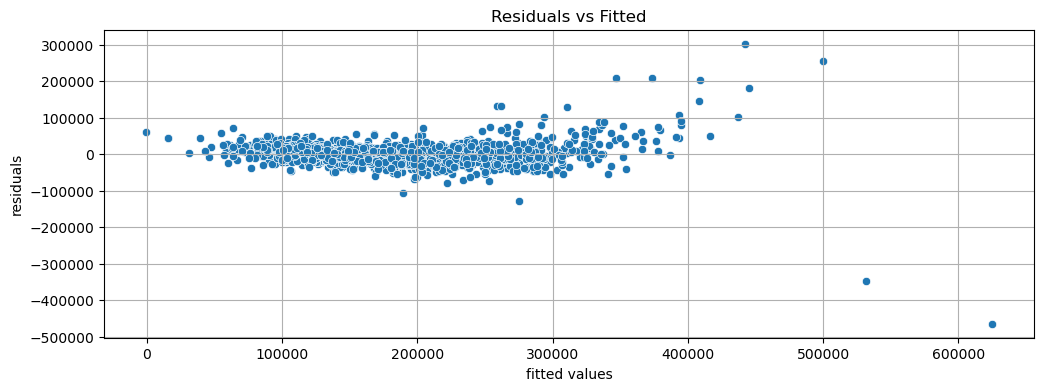

In [35]:
data_residuals = pd.DataFrame(np.array([model.fittedvalues, model.resid]).T, columns=['fitted values', 'residuals'])

plt.figure(figsize=(12,4))
sns.scatterplot(data=data_residuals, x='fitted values', y='residuals')
plt.title("Residuals vs Fitted")
plt.grid()
plt.show()

Looking at this plot, we can identify two exteme outliers with fitted values $> 500000$.

Let's find indexes of these observations:

In [36]:
np.argwhere(model.fittedvalues > 500000)

array([[ 509],
       [ 671],
       [1253]])

So, $509$th and $1253$th obesrvations could be identified as outliers, given the plot above.

To identify influential observations we can use Cook’s Distance:
$$D_i = \frac{(\hat\beta - \hat\beta_{(i)})^\top X^\top X (\hat\beta - \hat\beta_{(i)})}{(K + 1)\hat\sigma^2}$$
Let's calculate it and plot:

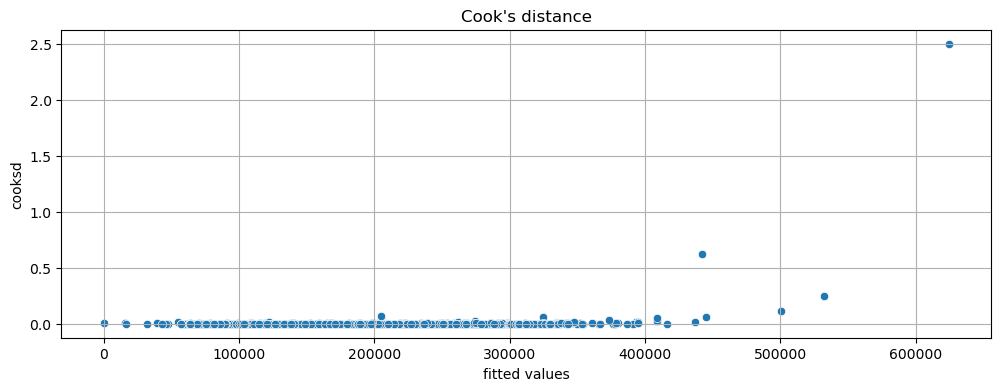

In [37]:
cooks = model.get_influence().cooks_distance[0]

data_cooks = pd.DataFrame(np.array([model.fittedvalues, cooks]).T, columns=['fitted values', 'cooksd'])

plt.figure(figsize=(12,4))
sns.scatterplot(data=data_cooks, x='fitted values', y='cooksd')
plt.title("Cook's distance")
plt.grid()
plt.show()

If $D_i > F_{K; N - K - 1; 0.5} \in [0.5;1]$, then the observation $i$ is influential. Here we can notice also two influential observations (one is the same - with the largest fitted value, and one - different from previous one).

Let's find indexes of these observations:

In [38]:
np.argwhere(cooks > 0.5)

array([[1142],
       [1253]])

So, $1142$th and $1253$th obesrvations could be identified as outliers, given the plot above.

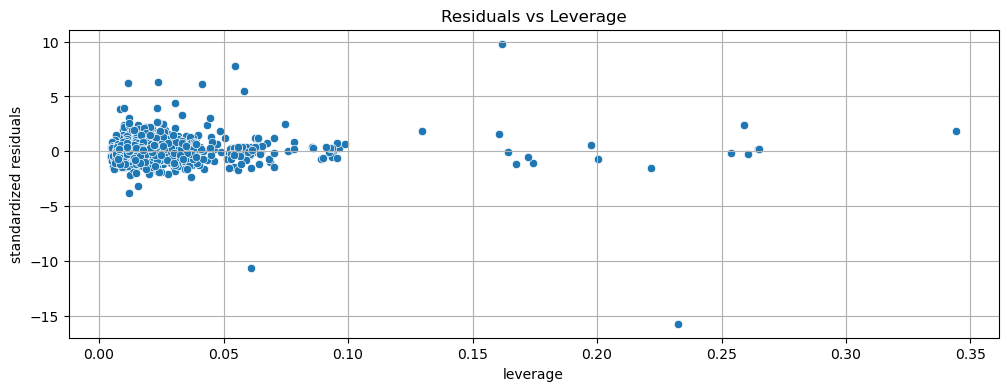

In [39]:
leverage = model.get_influence().hat_matrix_diag
standardized_residuals = model.get_influence().resid_studentized_internal

data_cooks = pd.DataFrame(np.array([leverage, standardized_residuals]).T, columns=['leverage', 'standardized residuals'])

plt.figure(figsize=(12,4))
sns.scatterplot(data=data_cooks, x='leverage', y='standardized residuals')
plt.title("Residuals vs Leverage")
plt.grid()
plt.show()

Here, we can see two or three extreme values, let's find its indexes:

In [40]:
np.argwhere((standardized_residuals < -10) | (standardized_residuals > 9))

array([[ 509],
       [1142],
       [1253]])

So, as previously $509$th, $1142$th and $1253$th obesrvations could be identified as outliers, given the plot above.

Now identify an observation with the highest leverage:

In [41]:
optimal_model.iloc[np.argmax(model.get_influence().influence)]

LotArea           15623.0
OverallQual          10.0
OverallCond           5.0
YearBuilt          1996.0
MasVnrArea            0.0
ExterQual             3.0
ExterCond             2.0
BsmtFinSF1         2096.0
GrLivArea          4476.0
BsmtFullBath          1.0
BedroomAbvGr          4.0
KitchenAbvGr          1.0
KitchenQual           4.0
TotRmsAbvGrd         10.0
Fireplaces            2.0
GarageCars            3.0
WoodDeckSF          171.0
EnclosedPorch         0.0
ScreenPorch           0.0
PoolArea            555.0
MSSubClass_20         0.0
MSSubClass_30         0.0
MSSubClass_40         0.0
MSSubClass_45         0.0
MSSubClass_50         0.0
MSSubClass_90         0.0
MSSubClass_120        0.0
MSSubClass_160        0.0
MSSubClass_190        0.0
Name: 1183, dtype: float64

To find the reasons, why it is so outstanding, let's at first look at the boxplots of the continious parameters distributions:

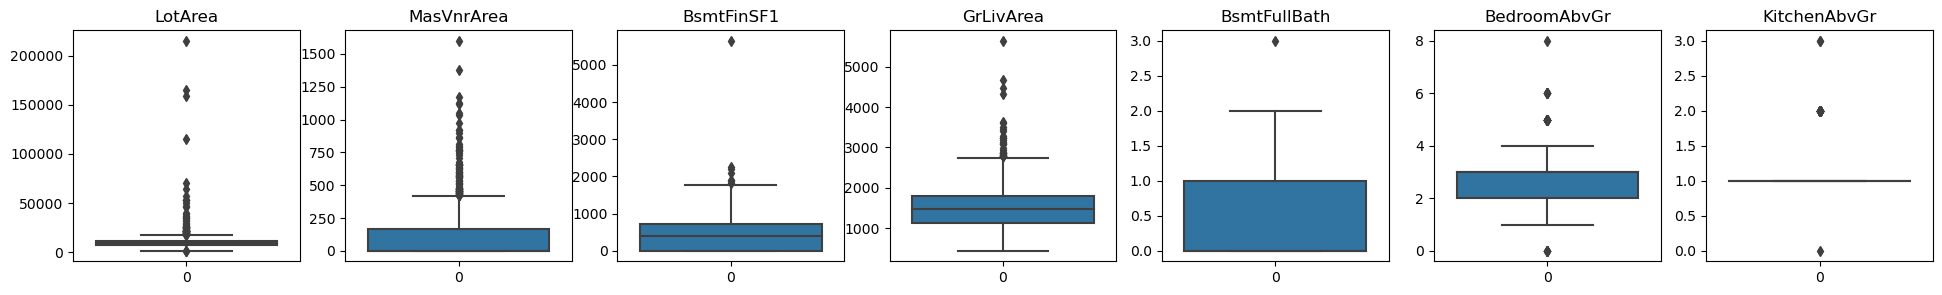

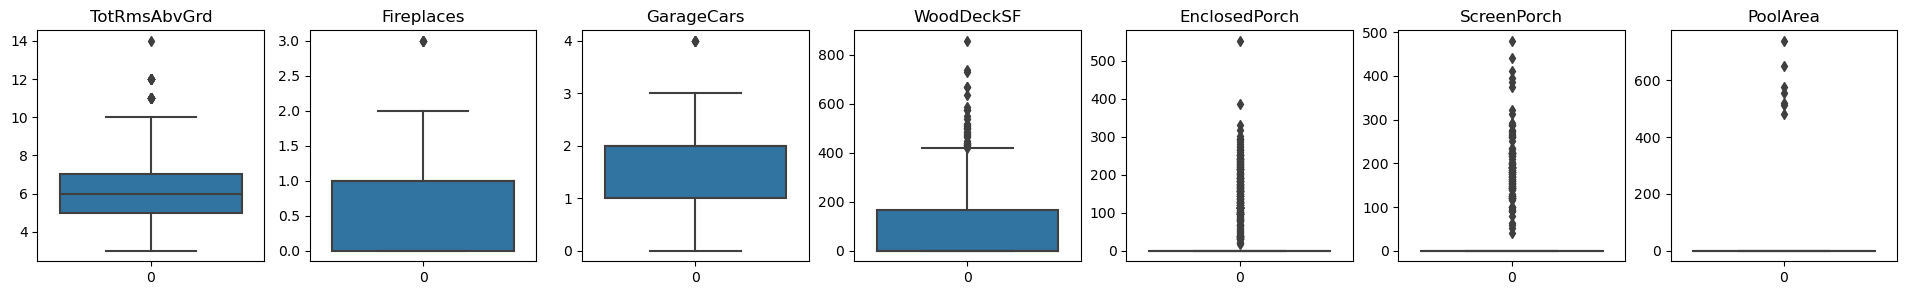

In [42]:
optimal_model_continious = optimal_model.drop([col for col in optimal_model.columns 
                                               if 'MSSubClass' in col 
                                                   or col in [
                                                       'OverallQual',
                                                       'OverallCond', 
                                                       'YearBuilt',
                                                       'ExterQual', 
                                                       'ExterCond', 
                                                       'KitchenQual'
                                                   ]], axis=1)

i = 1
for col in optimal_model_continious.columns:
    if (i - 1) % 7 == 0:
        plt.figure(figsize=(24, 3));
        i = 1
    
    plt.subplot(1, 7, i);
    sns.boxplot(np.array(optimal_model_continious[col]));
    plt.title(col);
    i += 1

From these boxplots we can notice that 'BsmtFinSF1', 'GrLivArea' and 'PoolArea' can make this observation so outstanding, because the values of these parameters are extreme inside its distributions.

Then observe the categorical variables, looking at its frequencies on the histograms:

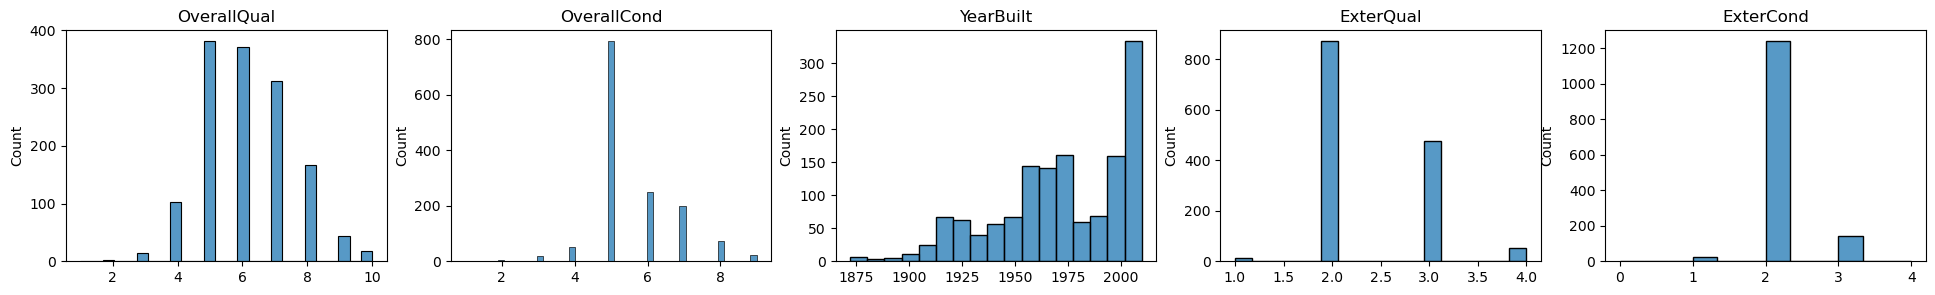

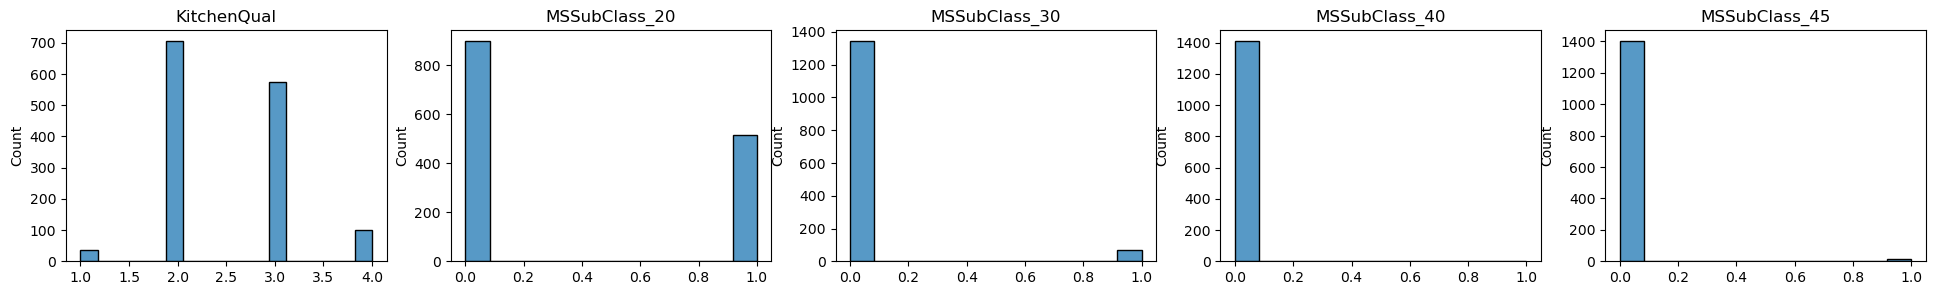

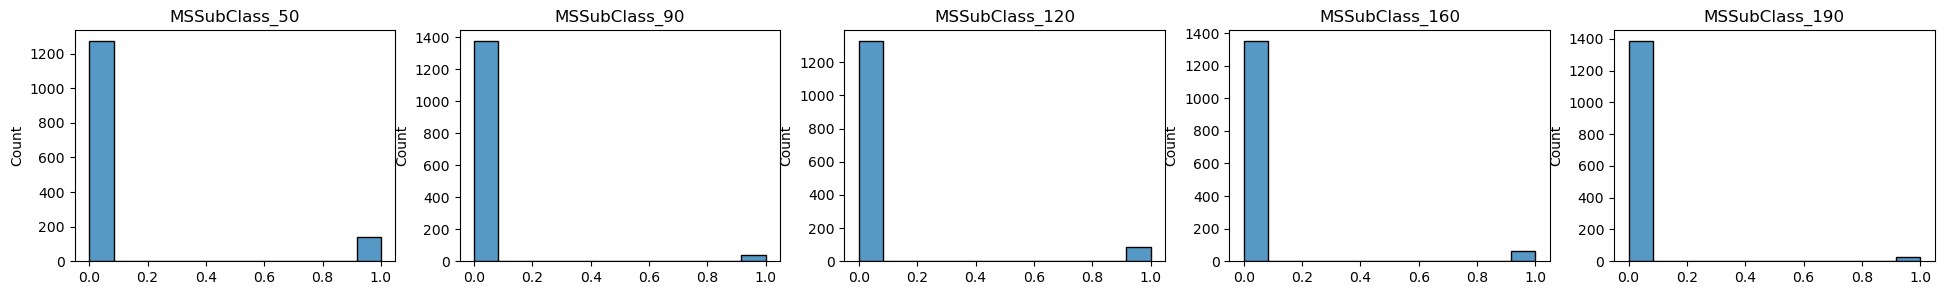

In [43]:
optimal_model_categorical = optimal_model.drop([col for col in optimal_model.columns 
                                               if 'MSSubClass' not in col 
                                                   and col not in [
                                                       'OverallQual',
                                                       'OverallCond', 
                                                       'YearBuilt',
                                                       'ExterQual', 
                                                       'ExterCond', 
                                                       'KitchenQual'
                                                   ]], axis=1)
i = 1
for col in optimal_model_categorical.columns:
    if (i - 1) % 5 == 0:
        plt.figure(figsize=(24, 3));
        i = 1
    
    plt.subplot(1, 5, i);
    sns.histplot(np.array(optimal_model_categorical[col]));
    plt.title(col);
    i += 1

From these histograms we can notice that 'OverallQual' and maybe 'KitchenQual' can additionally make this observation so outstanding, because as previously the values of these parameters are extreme inside its distributions.

So, in conclusion, values of 'BsmtFinSF1', 'GrLivArea', 'PoolArea', 'OverallQual' and 'KitchenQual' of this observation could have an significant impact on its leverage score.

## _9. Frequently data is missing. Pick up 5 rows in the data set and delete the value for LotArea. Implement at least two approaches to fill in these values. Write down the corresponding formulas/model and give motivation for your approach. If you use standard routines, then check and summarize how the data imputation is implemented. Note that for imputation you shall use the complete data set and not only the set of variables after feature selection._

First, let's look on the distribution of 'LotArea':

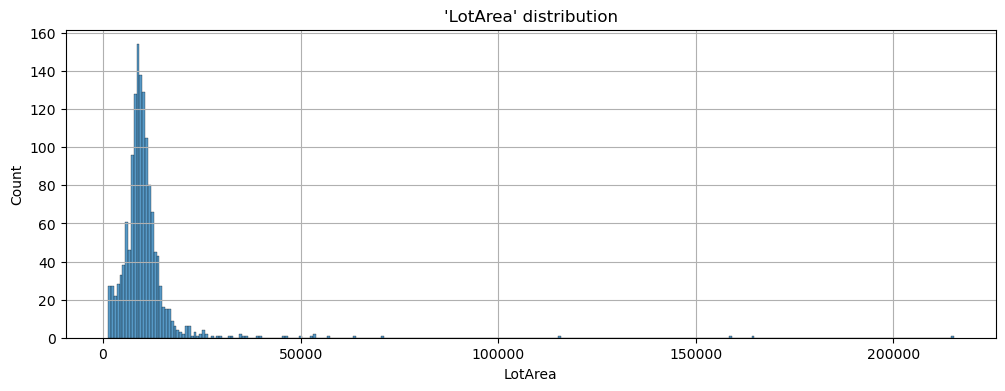

In [44]:
plt.figure(figsize=(12,4))
sns.histplot(np.array(processed_house_data['LotArea']));
plt.grid()
plt.title("'LotArea' distribution")
plt.xlabel("LotArea")
plt.show()

As the distribution of 'LotArea' is skewed, then mean imputation approach is not appropriate here, it would be better to do median imputation.

To find a median we just sort the 'LotArea' values and pick the middle one. Then fill missed data with this value.

In [45]:
temp_house_data = processed_house_data.copy()
indexes_to_drop = np.random.randint(0, len(temp_house_data['LotArea']), 5)
true_values = temp_house_data.loc[indexes_to_drop,'LotArea']
for i in indexes_to_drop:
    temp_house_data.loc[i,'LotArea'] = np.nan
true_values

Id
786      9790
1239    13072
793      9920
993      9760
1161     2280
Name: LotArea, dtype: int64

In [46]:
lot_area_median = temp_house_data['LotArea'].median()
lot_area_median

9492.0

So, it's a quick and simple method. However, it can reduce the variability of the data and might not be suitable if the data is not missing completely at random.

To provide more accurate imputations, it would be better to use regression imputation, the main idea of which is to train linear regression model for prediction of 'LotArea' based on the present data and then fill missed data with the predicted one.

To use this approach we need to find regressors of 'LotArea'. We can do the stepwise model selection procedure to find optimal model of 'LotArea' prediction:

In [47]:
eps = 1e-6
sfs = SequentialFeatureSelector(LinearRegression(), scoring='r2', direction='forward', tol=eps)

X = processed_house_data.drop(columns=['LotArea'])
y = processed_house_data['LotArea']

sfs = sfs.fit(X, y)
optimal_model_lot_area = X.loc[:, sfs.get_support()]

print(f"Selected {len(optimal_model_lot_area.columns)} parameters ({list(optimal_model_lot_area.columns)})")

Selected 11 parameters (['OverallQual', '1stFlrSF', '2ndFlrSF', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', 'PoolArea', 'MSSubClass_30', 'MSSubClass_120', 'MSSubClass_160', 'MSSubClass_180'])


Now let's train our model:

In [48]:
columns = ['LotArea']
columns.extend(optimal_model_lot_area.columns)
data_lot_area = temp_house_data[columns]

X = data_lot_area.dropna().drop(columns=['LotArea'])
y = data_lot_area.dropna()['LotArea']
    
model = sm.OLS(y, X).fit()

Having model trained, we can predict missed value:

In [49]:
model.predict(data_lot_area.drop(columns=['LotArea']).loc[indexes_to_drop,:])

Id
786     12747.983754
1239     8788.950396
793     12451.791361
993     11706.666112
1161     5799.192411
dtype: float64

So, here we can see that most of predicted values are close to the true values, that is significantly better than just filling with median value.

## _10. We consider now the model with SalePrices and the model with log(SalePrices). Run an appropriate test to decide which of the models is superior. Explain, the idea of the test and why you cannot make a similar decision using AIC/BIC, etc._

To conclude if the model with $'SalePrice'$ is better than the model with $log('SalePrice')$ we can use the test of $\delta$ of the following model:
$$y_i^* = x_i'\beta + \delta_{lin}(\log \hat{y_i} - \hat{\log y_i}) + u_i$$
If $H_0: \delta = 0$ is not rejected, then there is no additional valuable information in the log’s useful to forecast $y_i$ and the linear model should be preferred.

Now let's find $\hat{y}_i$ and $\hat{\log y}_i$, which corresponds to the fitted values of the model with $'SalePrice'$ and the model with $\log('SalePrice')$:

In [50]:
X = optimal_model
X = sm.add_constant(X)
y = processed_house_data['SalePrice']
model = sm.OLS(y, X).fit()

y_log = np.log(processed_house_data['SalePrice'])
model_log = sm.OLS(y_log, X).fit()

Then train the model $y_i^*$:

In [51]:
log_y_fitted = np.log(model.fittedvalues)
y_log_fitted = model_log.fittedvalues

X_test = X
X_test['delta'] = log_y_fitted - y_log_fitted
X_test['SalePrice'] = processed_house_data['SalePrice']
X_test = X_test.dropna()

y_test = X_test['SalePrice']
X_test = X_test.drop(columns=['SalePrice'])

model_test_1 = sm.OLS(y_test, X_test).fit()

Now let's calculate t-statistics of $\delta$:

In [52]:
beta_OLS = model_test_1.params
sigma_squared = model_test_1.resid.T @ model_test_1.resid / (len(y_test) - len(beta_OLS) - 1)
var = np.diag(sigma_squared * np.linalg.inv(X_test.T @ X_test))
t = (beta_OLS[-1]) / np.sqrt(var[-1])
t

-10.146076507902958

Then find rejection area for the test:

In [53]:
alpha = 0.05
t_emp = st.t.ppf(1 - alpha/2, len(y_test) - len(beta_OLS) - 1)

So, the rejection area is $B \in (-\infty; 1.9616) \cup (1.9616; +\infty)$. Thus the test statistics that we get is not in the rejection are, then we can reject $H_0$ with $95\%$ level of significance. Then there is an additional valuable information in the log’s useful to forecast $y_i$.

Now, let's test if log-linear model is better than the linear one. Then we will test $\delta$ of the following model:
$$y_i^* = x_i'\beta + \delta_{log}(\hat{y_i} - \exp(\hat{\log y_i})) + u_i$$
If $H_0: \delta = 0$ is not rejected, then there is no additional valuable information in the linear model useful to forecast $y_i$ and the log-linear model should be preferred.

In [54]:
y_fitted = model.fittedvalues
exp_y_log_fitted = np.exp(model_log.fittedvalues)

X_test = X
X_test['delta'] = y_fitted - exp_y_log_fitted
X_test['SalePrice'] = processed_house_data['SalePrice']
X_test = X_test.dropna()

y_test = X_test['SalePrice']
X_test = X_test.drop(columns=['SalePrice'])

model_test_2 = sm.OLS(y_test, X_test).fit()

In [55]:
beta_OLS = model_test_2.params
sigma_squared = model_test_2.resid.T @ model_test_2.resid / (len(y_test) - len(beta_OLS) - 1)
var = np.diag(sigma_squared * np.linalg.inv(X_test.T @ X_test))
t = (beta_OLS[-1]) / np.sqrt(var[-1])
t

-3.2861548003775427

So, here we also reject $H_0$ and then conclude that there is an additional valuable information in the linear model useful to forecast $y_i$.

Thus, both linear and log-linear are good models for prediction of 'SalePrice'. Maybe, log-linear would be a little bit better as the second test-statistics is closer to rejection area borders.

To compare AIC/BIC is not really fair, because it is based on the forecast errors, and forecast error of linear model is completely different than the forecast error of log-linear. So, looking at AIC/BIC for those models is not really correct way to do.

## _11. We wish to assess the predictive ability of the estimated regression. Consider the full model and the model after features selection. Compare the two models using leave-one-out CV and 5-fold CV. Explain the idea of this technique with formulas and draw a conclusion about the predictive ability of the two models._

In [56]:
full_model = processed_house_data.drop(columns=['SalePrice'])
y = processed_house_data['SalePrice']

To assess the predictive ability of the estimated regression it would be good to use cross validation procedure. We will try two approaches Leave-One-Out CV and 5-Fold CV.

__Leave-One-Out CV (LOOCV):__

For a dataset with $N $data points (samples), LOOCV involves using $N−1$ samples for training the model and the remaining 1 sample for testing.

This process is repeated $N$ times, each time with a different sample held out for testing.

Essentially, each sample gets a chance to be the test set once.

If $MSE_i$ is the error on the $i$th sample (when it's used as the test set). Then, the overall performance estimate $CV_{LOO}$ is calculated as:
$$CV_{LOO} = \frac{1}{N}\sum\limits_{i=1}^N MSE_i$$

Let's find cross validation scores for the full model and the model after features selection.

In [57]:
kf_cv = RepeatedKFold(n_splits=5)

kf_full_scores = cross_val_score(LinearRegression(), full_model, y, cv=kf_cv, scoring=make_scorer(mean_squared_error))
kf_optimal_scores = cross_val_score(LinearRegression(), optimal_model, y, cv=kf_cv, scoring=make_scorer(mean_squared_error))

kf_full_scores.mean(), kf_optimal_scores.mean()

(1469546288.6373456, 1330267527.3425803)

So, here we can see that the mean MSE for full model is greater than for the optimal model. So, optimal model provides less error than the full one.

Let's try 5-Fold CV.

__5-Fold CV (LOOCV):__

The dataset is randomly partitioned into 5 equal-sized subsets (or as equal as possible).

For each round, 4 subsets are used for training the model, and the remaining 1 subset is used for testing.

This process is repeated 5 times (folds), each time with a different subset used as the test set.

The performance measure is computed 5 times, once for each round.

If $E_j$ is the error on the $j$th fold (when it's used as the test set),

Then, the overall performance estimate $CV_{5-Fold}$ is calculated as:
$$CV_{5-Fold} = \frac{1}{5}\sum\limits_{j=1}^5 MSE_j$$

In [58]:
llo_cv = LeaveOneOut()

loo_full_scores = cross_val_score(LinearRegression(), full_model, y, cv=llo_cv, scoring=make_scorer(mean_squared_error))
loo_optimal_scores = cross_val_score(LinearRegression(), optimal_model, y, cv=llo_cv, scoring=make_scorer(mean_squared_error))

loo_full_scores.mean(), loo_optimal_scores.mean()

(1424323870.9142244, 1307944430.92349)

So, here we have the same result - the mean MSE for full model is greater than for the optimal model. 

So, in conclusion, based on two approaches, optimal model provides has better predictive ability, than the full one.

# Problem 6: Regression techniques

## _1. A nonlinear regression offers a flexible technique for modelling complex relationships. We wish to explain the SalePrices by YearBuilt. Consider only the first 500 observations for this purpose._

In [59]:
house_data_cropped = house_data[['YearBuilt', 'SalePrice']].head(500)
house_data_cropped

,YearBuilt,SalePrice
Id,,
1,2003,208500
2,1976,181500
3,2001,223500
4,1915,140000
5,2000,250000
...,...,...
496,1920,34900
497,1992,430000
498,1925,184000


### _(a) Make a bivariate scatter plot and estimate an appropriate linear (!) model. Add the regression line to the plot._

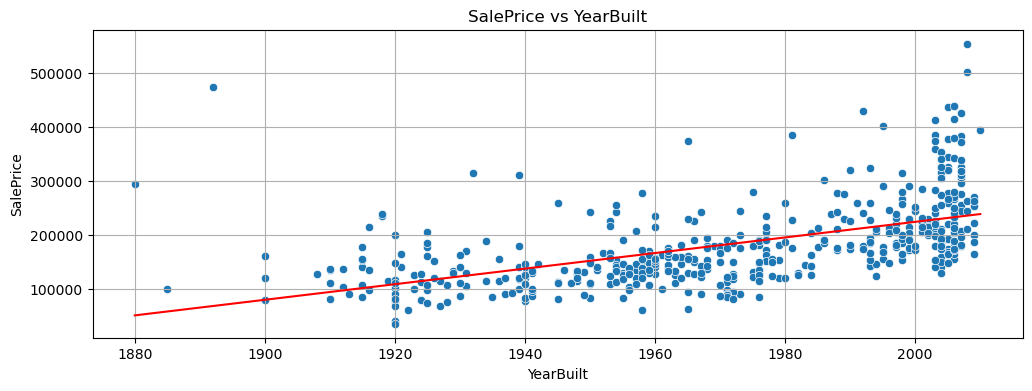

In [60]:
X = house_data_cropped['YearBuilt']
X = sm.add_constant(X)
y = house_data_cropped['SalePrice']
    
model = sm.OLS(y, X).fit()
y_pred_lr = model.fittedvalues

x_space = np.linspace(np.min(house_data_cropped['YearBuilt']), np.max(house_data_cropped['YearBuilt']))

plt.figure(figsize=(12,4))
sns.scatterplot(x='YearBuilt', y='SalePrice', data=house_data_cropped)
plt.plot(x_space, sm.add_constant(x_space) @ model.params, 'r')
plt.title("SalePrice vs YearBuilt")
plt.grid()
plt.show()

### _(b) Estimate now an appropriate nonlinear regression which might fit the data better. Add the regression curve to the plot and compare (quantitatively) the fit with the fit of the linear model._

We can notice that linear model predicts 'SalePrice' pretty good, but we can try to improve it by non-linear model.

Looking at the plot we can assume that the proper model will be $y_i = (x_i - \beta_1)^{\beta_2} + \beta_3$. Let's try to find $\beta_j$:

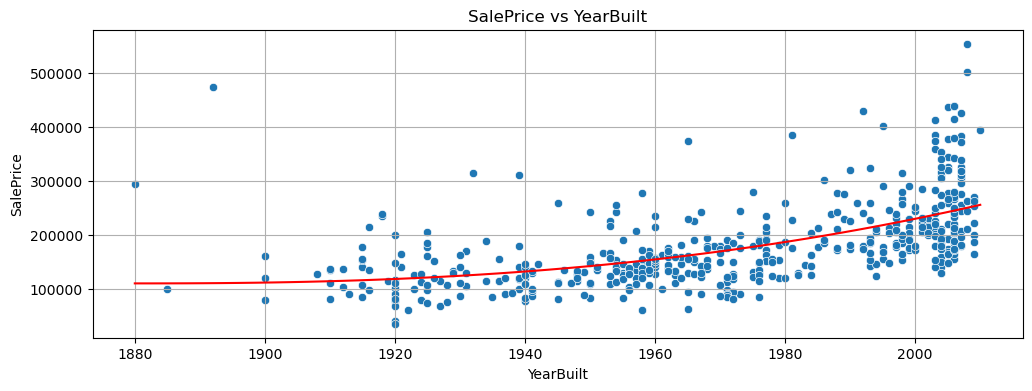

In [61]:
def func(x, a, b, c):
    return (x - a)**b + c

beta_nls, pcov = curve_fit(func, house_data_cropped['YearBuilt'], house_data_cropped['SalePrice'])
y_pred_nls = func(house_data_cropped['YearBuilt'], *beta_nls)

plt.figure(figsize=(12,4))
sns.scatterplot(x='YearBuilt', y='SalePrice', data=house_data_cropped)
plt.plot(x_space, func(x_space, *beta_nls), 'r')
plt.title("SalePrice vs YearBuilt")
plt.grid()
plt.show()

In [62]:
print(f"MSE for linear regression model is:\t{mean_squared_error(y, y_pred_lr)}")
print(f"MSE for non-linear regression model is:\t{mean_squared_error(y, y_pred_nls)}")

MSE for linear regression model is:	4297426767.369774
MSE for non-linear regression model is:	3896917146.697345


So, we managed to find a good non-linear model, which provides less MSE than linear one.

### _(c) Explain in your own words, why all the classical tests and inferences are not directly applicable to the NLS estimators._

Since the resulting $\hat{\beta}$ is a non-linear function of the residuals $u_i$, then the unbiasedness can not be proven in simple way. Also the variance of $\hat{\beta}$ is not easy to derive.

As the exact distribution of $\hat{\beta}$ is not Gaussian, then all the inferences, like tests, could be valid only asymptotically relying only on the Central Limit Theorem. Classical tests often assume that the error terms are normally distributed with constant variance (homoscedasticity). In NLS, the relationship between the variance of the error terms and the independent variables can be more complex, leading to heteroscedasticity. Moreover, the error distribution might not be normal, especially if the nonlinear transformation skews the distribution of the error terms.

Unlike OLS, which has a closed-form solution, NLS might converge to a local minimum instead of the global minimum, depending on the starting values and the nature of the objective function. This can lead to unreliable parameter estimates and subsequently affect the inference.

### _(d) What kind of problems might arise if we decide to fit a non-linear regression using all explanatory variables?_

Increasing of explanatory variables significantly increases a number of risks. 

Non-linear models can be highly flexible and capable of capturing complex relationships in the data that can lead to overfitting, where the model captures the noise in the data rather than the underlying trend. The model might find complex patterns that do not generalize well to unseen data.

Non-linear relationships can mupltiply the multicollinearity issues. Multicollinearity can make coefficients unstable and difficult to interpret. It can also make the model more sensitive to changes in the model specification.

Adding many explanatory variables can also make this interpretation even more challenging, as the effect of any single variable on the dependent variable might depend on the values of other variables in a complex and non-intuitive way.

There is also a high risk of non-convergence or local convergence. This risk is exacerbated when the model is complex and has many explanatory variables.

## _2. The ridge and lasso regressions are regularisation techniques used to stabilize the estimation._
### _(a) Explain in your own words the idea of the lasso regression. Sketch a situation when a simple linear regression fails, but the lasso regression still can be estimated. Why do we need to maximize the objective function numerically (in contrary to ridge)._

Imagine the case, when we have many features in the model, then built model tend to have high complexity. Thus, we face with bias-variance trade-off problem. Of course, some of the features have a little impact on the target, or even no impact. Generally if the complexity increases, then MSE decreases and it leads to overfiting.

To solve these issues we can use regularization procedure, the main aim of which is to penalize the loss function for the model complexity.

Typically we had:
$$L(y, \hat{y}) \rightarrow min \qquad w.r.t \qquad\theta$$
where $\theta$ - all the model parameters.

Regularization introduces an additional function of $\theta$:
$$L(y, \hat{y}) + \lambda J(\theta) \rightarrow min \qquad w.r.t \qquad\theta$$
where $J(\theta)$ is a penalty for the complexity and it typically depends on the parameters (or/and their number).

There are some approaches of $J(\theta)$, one of them is Lasso regression.
$$\sum\limits_{i=1}^n (y_i - \hat y_i)^2 + \lambda \sum\limits_{j=1}^k |\beta_j| \rightarrow min \qquad w.r.t \qquad\beta$$

In case, when we have a large number of features linear regression can fail due to overfiting. The model tries to assign a coefficient to each feature. It will capture not only the true underlying relationships, but also the noise in the training data. This overfitting will result in poor model performance on new test data.

Then if we use Lasso regression it will add an $L_1$ penalty which encourages sparsity in the coefficients. In our scenario, this means Lasso will drive the coefficients of less important features towards zero. Thus the model performs automatic feature selection, considering only the most relevant features in predicting the target value. By driving unnecessary coefficients to zero, Lasso regression reduces the model's complexity. This simplicity makes the model less likely to overfit the training data and more likely to generalize well to new data, which we need to predict.

We need to use numerical methods to minimize the objective function in lasso regression due to its nature, because the $L_1$ penalty introduces non-differentiability at zero, preventing an analytical solution.

### _(b) For the usual regression model the variables are rarely normalized/standardized. However, in the case of the lasso regression the scaling becomes crucial. Why? Scale your data. Can/should the binary variables be scaled in the same fashion? What about factor variables (for example, FireplaceQu)?_

In Lasso regression, the $L_1$ penalty term is the sum of the absolute values of the coefficients. Initially all the coefficients are equally for us, but due to the fact that variables could be on different scales, the coefficients also will not. Therefore, we need to standardize our data to make coeficients initially equally. A coefficient corresponding to a feature with a small scale will be penalized more heavily than a coefficient corresponding to a feature with a large scale.

Standartization could cause some problems with categorical data (binary and ordinal). 

Speaking about binary data, actually we don't need to do the standardization, because we encoded these variables into dummies, which are either $0$ or $1$.

We also encoded ordinal variables into numerical ones with interval $1$ between values. Standardization maintains the order of the values, which is crucial for ordinal variables. A higher value will still be higher after standardization, and a lower value will still be lower. As the interval between its values is equal and order would be preserved, then we can also imply standardization to ordinal variables.

So, let's do the standardization.

In [63]:
standardized_data = pd.DataFrame()
for col in processed_house_data.columns:
    if 'MSSubClass' not in col:
        standardized_data[col] = st.zscore(processed_house_data[col])
    else:
        standardized_data[col] = processed_house_data[col]
standardized_data

,LotArea,Street,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,ExterCond,BsmtFinSF1,...,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90,MSSubClass_120,MSSubClass_160,MSSubClass_180,MSSubClass_190
Id,,,,,,,,,,,,,,,,,,,,,
1,-0.206423,0.065326,0.634546,-0.536528,1.039872,0.870622,0.497230,1.041021,-0.252232,0.554259,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.092677,0.065326,-0.102279,2.165889,0.150573,-0.449333,-0.578062,-0.700592,-0.252232,1.151783,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.070524,0.065326,0.634546,-0.536528,0.973998,0.821735,0.310700,1.041021,-0.252232,0.070967,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.097622,0.065326,0.634546,-0.536528,-1.858586,-0.742657,-0.578062,-0.700592,-0.252232,-0.522163,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.368241,0.065326,1.371371,-0.536528,0.941061,0.723960,1.342103,1.041021,-0.252232,0.442223,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,-0.259141,0.065326,-0.102279,-0.536528,0.908124,0.723960,-0.578062,-0.700592,-0.252232,-0.996667,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1457,0.260924,0.065326,-0.102279,0.364278,0.216447,0.137314,0.074794,-0.700592,-0.252232,0.738788,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1458,-0.147868,0.065326,0.634546,3.066695,-1.002223,1.017284,-0.578062,2.782633,2.596981,-0.392553,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### _(c) Run a lasso regression with $λ > 0$. Plot the estimated parameters as functions of $λ$. Which value of $λ$ would you recommend? If it is easy to implement, then determine the optimal $λ$ by cross-validation._

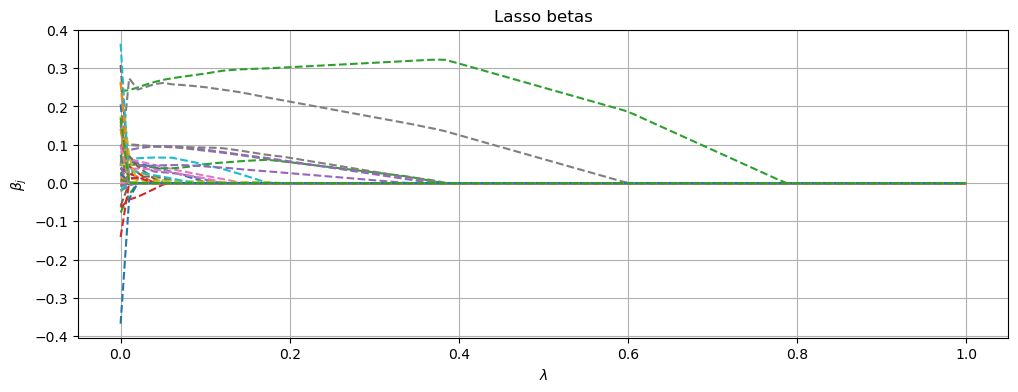

In [64]:
X = standardized_data.drop(columns=['SalePrice'])
y = standardized_data['SalePrice']

lambda_grid = np.linspace(1e-6, 1, num=100)

results = np.array([Lasso(alpha=lambda_).fit(X, y).coef_ for lambda_ in lambda_grid]).T

plt.figure(figsize=(12,4))
for betas in results:
    plt.plot(lambda_grid, betas, '--')
plt.title("Lasso betas")
plt.xlabel(r"$\lambda$")
plt.ylabel(r"$\beta_j$")
plt.grid()
plt.show()

The ideal value of $\lambda$ typically corresponds to a point where the plot starts to stabilize, indicating that further reduction in lambda doesn't substantially change the coefficients, and the model includes the most relevant features without overfitting. Given the plots above I would choose $\lambda$ somewhere at the beginning near $0.05$, as most of $\beta_j$ converge to zero very fast. 

To find find optimal value of $\lambda$ we can use 10-fold CV:

In [65]:
lasso_lambda_opt = LassoCV(cv=10).fit(X, y).alpha_
lasso_lambda_opt

0.0012822301701525653

### _(d) Consider the ridge regression. Estimate it for a fixed (and optimal if possible) value of $λ$. Compare the estimated parameters and their variances for ridge and for the multiple linear regression. What would you expect from such a comparison. Remember to fit the linear regression to scaled variables._

Let's estimate ridge regression for optimal $\lambda$ using 10-Fold CV:

In [66]:
ridge_model = RidgeCV(cv=10).fit(X, y)
ridge_model.coef_

array([ 0.05357313,  0.00826863,  0.23594832,  0.06645648,  0.11638651,
        0.00411096,  0.06976322,  0.09823488, -0.02241991,  0.0556878 ,
        0.00459829, -0.006238  ,  0.05776305,  0.00844965,  0.06471954,
        0.15351901,  0.00275248,  0.17514234,  0.05092196,  0.00754505,
        0.02469327,  0.00929936, -0.07376448, -0.05603267,  0.08168806,
        0.09737142,  0.0396861 ,  0.0960979 , -0.00477959,  0.03856358,
       -0.0077283 ,  0.00600807,  0.00899336,  0.03768057, -0.01842418,
       -0.00345741, -0.00060945, -0.00966876,  0.15191282,  0.19712816,
        0.03008837,  0.0741415 ,  0.00050073, -0.12096599, -0.01392545,
       -0.06199285,  0.00906562,  0.03763767,  0.04479311, -0.09652106,
       -0.32314473,  0.02804853,  0.04323357])

An optimal $\lambda$ is:

In [67]:
ridge_lambda_opt = ridge_model.alpha_
ridge_lambda_opt

10.0

In [68]:
linear_model = LinearRegression().fit(X, y)
linear_model.coef_

array([ 5.24762856e-02,  9.37079126e-03,  2.41093987e-01,  6.71655975e-02,
        1.40446998e-01,  3.30656764e-03,  7.09269032e-02,  9.65460526e-02,
       -2.29125524e-02,  5.24782347e+11,  1.88317728e+11,  5.04266894e+11,
       -4.66462553e+11,  4.51683538e-03, -6.06383861e+11, -6.88940576e+11,
       -7.77728000e+10,  8.29179432e+11,  4.96611936e-02,  8.19757043e-03,
        2.43081252e-02,  1.40082850e-02, -7.71718959e-02, -6.36383203e-02,
        7.98650828e-02,  9.81238169e-02,  4.07003579e-02,  9.90625173e-02,
       -9.40845727e-03,  3.86446059e-02, -5.72655110e-03,  6.84463496e-03,
        9.51107839e-03,  3.83453369e-02, -1.97143555e-02, -5.36346436e-03,
       -7.32421875e-04, -9.15527344e-03, -4.34527637e+10, -4.34527637e+10,
       -4.34527637e+10, -4.34527637e+10, -4.34527637e+10, -4.34527637e+10,
       -4.34527637e+10, -4.34527637e+10, -4.34527637e+10, -4.34527637e+10,
       -4.34527637e+10, -4.34527637e+10, -4.34527637e+10, -4.34527637e+10,
       -4.34527637e+10])

Comparing coefficients $\beta_j$, which we get by ridge regression model and linear one, we can notice that all the coefficients, provided by ridge regression are in interval $(0;1)$. In the contrary among the coefficients, provided by linear regression we get some of them with a huge values. So, we can concluded that ridge regression significantly reduced the variance of the coefficient values.

## _3. In the next step we model SalePrice using regression trees._
### _(a) Let GrLivArea be the first variable used for splitting. Write down the corresponding optimization problem and explain how the optimization works._

Initially, the algorithm considers all the data points in one branch (the root of the tree).

Then it searches for the best splitting point $s$ for 'GrLivArea' by trying different values of $s$:
$$R_1(j, s) = \{X|X_j \leq s\} \qquad\qquad R_2(j, s) = \{X|X_j > s\}$$

For each potential split, the algorithm calculates the $SSE$ for both new branches (left and right). It chooses the split that minimizes the total $SSE$ ($SSE_{left}$ + $SSE_{right}$) as the best split for 'GrLivArea':
$$\sum\limits_{i:x_i \in R_1(j,s)}(y_i - \hat{y}_{R_1})^2 + \sum\limits_{i:x_i \in R_2(j,s)}(y_i - \hat{y}_{R_2})^2$$
where $\hat{y}_{R_p}$ is the mean of observations in the $p$-th region.

The dataset is separated into two regions based on the chosen point $s$.

The process is recursively repeated for each branch (left and right) until a stopping criterion is met.

The final result is a decision tree structure, where each internal node represents a split based on 'GrLivArea', and the "leaves" contain the predicted 'SalePrice' values for the corresponding subsets of data.

### _(b) (optional) Implement the optimization manually. Order the values of GrLivArea. Make a grid for potential split points in such a way, that every element of the grid is in the middle of two subsequent GrLivArea observations (i.e. $\frac{x_{(i)} + x_{(i+1)}}{2}$). Compute the objective function for every element of the grid and plot it as a function of the split point. Compare your results with R/Python results (use this feature as a single variable and set number of splits to 1)._

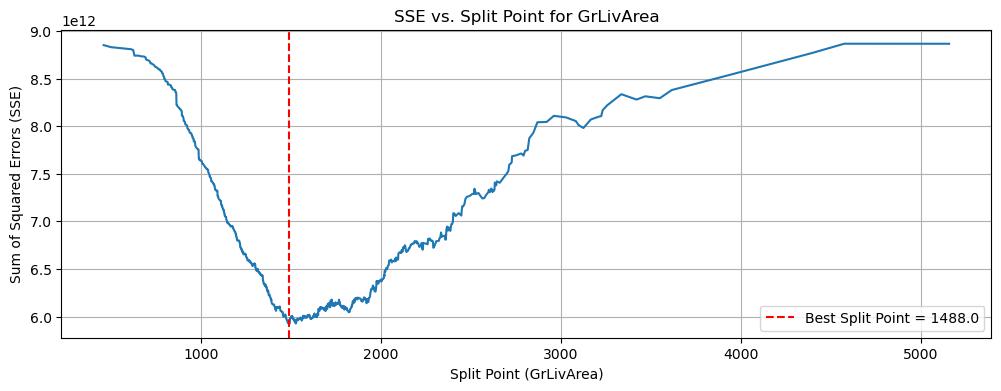

Best Split Point: 1488.0


In [69]:
ordered_data = processed_house_data[['GrLivArea', 'SalePrice']]
ordered_data = ordered_data.sort_values(by=['GrLivArea'])

X = np.array(ordered_data['GrLivArea'])
y = np.array(ordered_data['SalePrice'])

split_points = [(X[i] + X[i+1]) / 2 for i in range(len(X) - 1)]
best_sse = np.inf
best_split_point = None
sse_values = []

for split_point in split_points:
    left_branch = y[X <= split_point]
    right_branch = y[X > split_point]
    
    sse_left = sum((y[:len(left_branch)] - np.mean(left_branch))**2)
    sse_right = sum((y[-len(right_branch):] - np.mean(right_branch))**2)
    
    total_sse = sse_left + sse_right
    sse_values.append(total_sse)
    
    if total_sse < best_sse:
        best_sse = total_sse
        best_split_point = split_point

plt.figure(figsize=(12,4))
plt.plot(split_points, sse_values)
plt.axvline(x=best_split_point, color='red', linestyle='--', label=f'Best Split Point = {best_split_point}')
plt.title('SSE vs. Split Point for GrLivArea')
plt.xlabel('Split Point (GrLivArea)')
plt.ylabel('Sum of Squared Errors (SSE)')
plt.legend()
plt.grid()
plt.show()

print(f'Best Split Point: {best_split_point}')

In [70]:
X = np.array(processed_house_data['GrLivArea']).reshape(-1, 1)
y = np.array(processed_house_data['SalePrice']).reshape(-1, 1)

tree_regressor = DecisionTreeRegressor(max_depth=5).fit(X, y)
split_point = tree_regressor.tree_.threshold[0]
print(f'Best Split Point, provided by software: {split_point}')

Best Split Point, provided by software: 1488.0


### _(c) Consider now the variable OverallQual. It takes $10$ different ordered values from “very poor” to “very excellent”. How would you determine the optimal split for this type of a variable? Provide details of your ideas. Implementation is not needed._

We can find an average predicted value $\hat y$ and MSE ($\sum (y - \hat y)^2$) per each category. 

Then for each category, we split the data into two subsets: the left subset (values less than or equal to the category) and the right subset (values greater than the category). Then we calculate the MSE for both the left and right subsets using the predicted averages obtained in the previous step and choose the smallest sum. The correspondent point will be the best point to split tree by,

### _(d) Obviously you can get very long trees. Tree prunning helps to get trees of a reasonable size. Fit a CART to the data and prune it to have at most $10$ splits. Find the value of the complexity parameter for the trained tree._

So, let's find an optimal tree. The sequence of trees $T_0$ (no splits) to $T_m$ (m splits) uniquely determines the sequence of possible $\alpha$’s.

Then, find optimal $\alpha$ and corresponded tree with at most $10$ splits using cross validation minimizing MSE.

In [72]:
X = standardized_data.drop(columns=['SalePrice'])
y = standardized_data['SalePrice']

tree_regressor = DecisionTreeRegressor(random_state=42)
tree_regressor.fit(X, y)

max_splits = 10
alphas = tree_regressor.cost_complexity_pruning_path(X, y).ccp_alphas

best_alpha = None
best_mse = float('inf')

for alpha in alphas:
    regressor = DecisionTreeRegressor(random_state=42, ccp_alpha=alpha)
    regressor.fit(X, y)
    
    if (regressor.tree_.node_count - 1)/2 > max_splits:
        continue
        
    mse = -cross_val_score(regressor, X, y, cv=10, scoring='neg_mean_squared_error').mean()
    if mse < best_mse:
        best_mse = mse
        best_alpha = alpha

pruned_regressor = DecisionTreeRegressor(random_state=42, ccp_alpha=best_alpha)
pruned_regressor.fit(X, y)
splits_number = (pruned_regressor.tree_.node_count - 1)/2

best_alpha, splits_number, best_mse

(0.013647629716120838, 7.0, 0.2859510946260289)

So, an optimal $\alpha$ for getting tree with at most $10$ splits is $\alpha = 0.01$ minimizing MSE, given this we get a tree even with $7$ split providing MSE $0.285$.

### _(e) The complexity parameter uniquely determines the tree. What does it imply? What happens to the tree if we strongly increase or decrease the complexity parameter? Check it for the given tree and data._

The complexity parameter in the context of decision trees plays a crucial role in controlling the balance between tree complexity and fitting to the training data.

When the complexity parameter is set to a specific value, it determines the criteria for deciding when to stop growing the tree (pruning). This involves cutting branches or nodes of the tree that do not significantly improve the model's performance on the validation set. By adjusting the complexity parameter, we essentially control the size and depth of the tree that identify the tree.

Increasing of the complexity parameter leads to more aggressive pruning - the tree becomes simpler with less nodes and splits.

In the contrary, decreasing of the complexity parameter (ccp_alpha) leads to less aggressive pruning and the tree becomes more complex with more nodes and splits.

Let's check it:

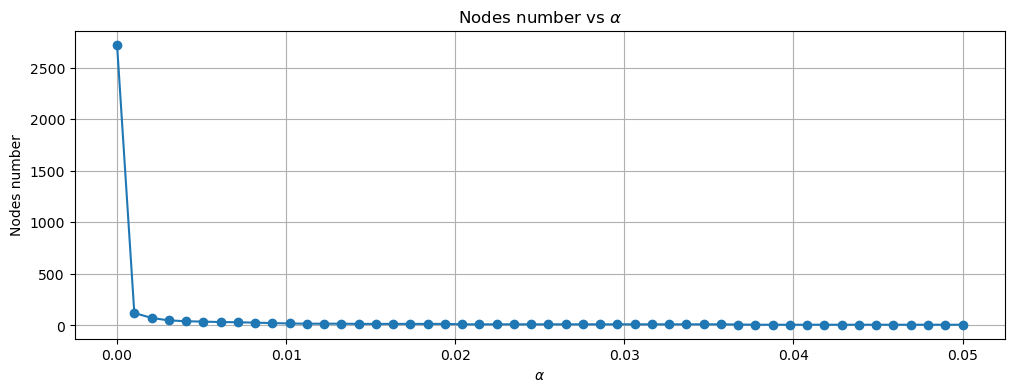

In [73]:
x_space = np.linspace(1e-12, 0.05, 50)
y_space = np.array([DecisionTreeRegressor(random_state=42, ccp_alpha=alpha).fit(X, y).tree_.node_count for alpha in x_space])

plt.figure(figsize=(12,4))
plt.plot(x_space, y_space, marker='o')
plt.title(r"Nodes number vs $\alpha$")
plt.xlabel(r"$\alpha$")
plt.ylabel("Nodes number")
plt.grid()
plt.show()

As we concluded greater complexity parameter ($0.01$) leads to less depth ($4$), and smaller ($0.0001$) - to more depth ($19$),

### _(f) Check the value of the improvement in the first split. Explain the idea of improvement and provide numerical expression how this improvement is computed for the first split._

The idea of improvement is to measure the reduction in MSE achieved by making a specific split in the data. A split is considered beneficial if it leads to less MSE in the target variable within the resulting child nodes compared to the MSE in the parent node.

Here is the numerical expression for improvement:
$$Improvement = \frac{K_{parent} \cdot MSE_{parent} - (K_{left} \cdot MSE_{left} + K_{right} \cdot MSE_{right})}{K_{parent} \cdot MSE_{parent}}$$

In [74]:
tree_regressor = DecisionTreeRegressor(random_state=42, ccp_alpha=best_alpha, max_depth=1)
tree_regressor.fit(X, y)

split_point = tree_regressor.tree_.threshold[0]
left_branch = y[y <= split_point]
right_branch = y[y > split_point]

sse_parent = np.sum((y - np.mean(y))**2)
sse_left = np.sum((left_branch - np.mean(left_branch))**2)
sse_right = np.sum((right_branch - np.mean(right_branch))**2)
improvement = (sse_parent - (sse_left + sse_right))/sse_parent * 100

improvement

57.92071192891856

So, in our case in the first split value of the improvement is $57.9\%$.

### _(g) Compute the importance of the variables and compare the results to the importances from lasso (remaining variables) and linear regression._

In [75]:
tree_feature_importances = DecisionTreeRegressor(random_state=42).fit(X, y).feature_importances_
lasso_feature_importances = Lasso(lasso_lambda_opt).fit(X, y).coef_
lr_feature_importances = LinearRegression().fit(X, y).coef_

print("Column\t\tDecision Tree\t\t Lasso \t\t Linear Regression\n")
for feature, tree, lasso, lr in zip(X.columns, tree_feature_importances, lasso_feature_importances, lr_feature_importances):
    print(f"{feature:<20}{tree:.6f}\t\t{lasso:.6f}\t\t{lr:.6f}")

Column		Decision Tree		 Lasso 		 Linear Regression

LotArea             0.014407		0.052961		0.052476
Street              0.000016		0.006381		0.009371
OverallQual         0.635941		0.239226		0.241094
OverallCond         0.004422		0.065850		0.067166
YearBuilt           0.024973		0.121880		0.140447
YearRemodAdd        0.007752		0.001539		0.003307
MasVnrArea          0.003413		0.070415		0.070927
ExterQual           0.000000		0.097318		0.096546
ExterCond           0.001301		-0.021121		-0.022913
BsmtFinSF1          0.024799		0.062620		524782347117.230286
BsmtFinSF2          0.000466		0.006368		188317727931.616089
BsmtUnfSF           0.004533		-0.000000		504266894319.414490
TotalBsmtSF         0.032983		0.045043		-466462553411.660217
HeatingQC           0.001180		0.006697		0.004517
1stFlrSF            0.018735		0.000000		-606383861234.089478
2ndFlrSF            0.042763		0.065706		-688940576432.631470
LowQualFinSF        0.000061		-0.006743		-77772799961.933792
GrLivArea           0.104880		0

Comparing the results we can notice, that the coefficients of Decision Tree and Lasso are very similar, but in most cases the coefficients of Decision Tree are the smallest one. So, the coefficients of Decision Tree are the most regularized. However, for Lasso approach would be still better to use for feature selection. Speaking about linear regression coefficients we can see that it contains a huge values for some features.

### _(h) Here we apply the bootstrap technique to estimate the distribution of the parameters of a linear regression. Consider the first $10$ features only. For every step of the bootstrap draw with replacement a sample of the same size as the original sample. Estimate the parameters by OLS and store the parameters for LotArea and Street. Repeat this $1000$ times. Subsequently plot the histogram (or KDE) for these two parameters and compare them with the usual normal density (with mean $\hat\beta$ and variance given by the diagonal element of $\sigma^2(X^\top X)^{−1}$). Is using bootstrap a reasonable approach here?_

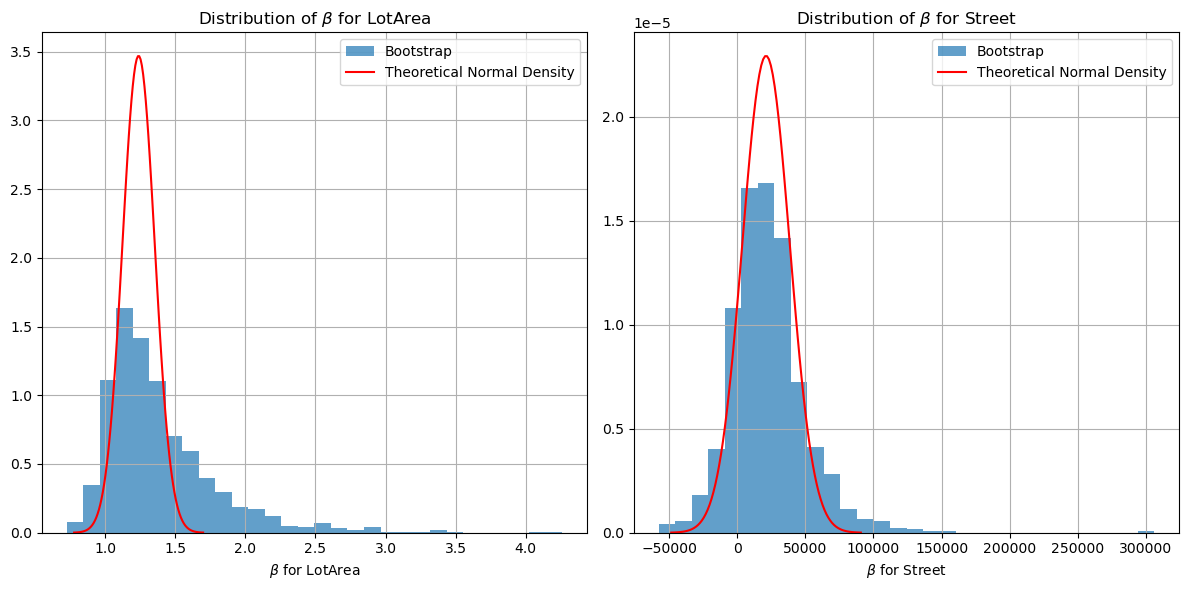

In [76]:
selected_features = processed_house_data.columns[:10]

X = processed_house_data[selected_features]
y = processed_house_data['SalePrice']

model_original = LinearRegression()
model_original.fit(X, y)

beta_hat = model_original.coef_
sigma_squared = np.mean((y - model_original.predict(X))**2)

var_beta = np.sqrt(np.diagonal(np.linalg.inv(X.T @ X) * sigma_squared))

n_bootstrap = 1000

beta_lot_area_bootstrap = np.zeros(n_bootstrap)
beta_street_bootstrap = np.zeros(n_bootstrap)

for i in range(n_bootstrap):
    bootstrap_sample = processed_house_data.sample(frac=1, replace=True)

    X_bootstrap = bootstrap_sample[selected_features]
    y_bootstrap = bootstrap_sample['SalePrice']

    model = LinearRegression()
    model.fit(X_bootstrap, y_bootstrap)

    beta_lot_area_bootstrap[i] = model.coef_[selected_features == 'LotArea']
    beta_street_bootstrap[i] = model.coef_[selected_features == 'Street']

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(beta_lot_area_bootstrap, bins=30, density=True, alpha=0.7, label='Bootstrap')
plt.xlabel(r'$\beta$ for LotArea')
plt.title(r'Distribution of $\beta$ for LotArea')

x_values = np.linspace(beta_hat[selected_features == 'LotArea'] - 4 * var_beta[selected_features == 'LotArea'],
                       beta_hat[selected_features == 'LotArea'] + 4 * var_beta[selected_features == 'LotArea'], 100)
plt.plot(x_values, st.norm.pdf(x_values, beta_hat[selected_features == 'LotArea'], var_beta[selected_features == 'LotArea']),
         'r-', label='Theoretical Normal Density')
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.hist(beta_street_bootstrap, bins=30, density=True, alpha=0.7, label='Bootstrap')
plt.xlabel(r'$\beta$ for Street')
plt.title(r'Distribution of $\beta$ for Street')

x_values = np.linspace(beta_hat[selected_features == 'Street'] - 4 * var_beta[selected_features == 'Street'],
                       beta_hat[selected_features == 'Street'] + 4 * var_beta[selected_features == 'Street'], 100)
plt.plot(x_values, st.norm.pdf(x_values, beta_hat[selected_features == 'Street'], var_beta[selected_features == 'Street']),
         'r-', label='Theoretical Normal Density')
plt.legend()
plt.tight_layout()
plt.grid()
plt.show()

Here we can notice that bootstrap histograms are a little bit wider thatn theoretical normal density. Histogram for LotArea is also a little bit right-skewed. But in most using bootstrap a reasonable approach is reasonable. Due to the bootstraping, we identified the variability and potential deviations from normality in our parameter estimates.

### _(i) Having the sample of the parameters compute the confidence interval defined by $2.5\%$ and $97.5\%$ quantiles of the sample. Compare to the confidence intervals based on the assumption of normality._

In [77]:
alpha = 0.05

ci_lot_area_bootstrap = np.percentile(beta_lot_area_bootstrap, [2.5, 97.5])
ci_street_bootstrap = np.percentile(beta_street_bootstrap, [2.5, 97.5])

ci_lot_area_normal = [beta_hat[selected_features == 'LotArea'] - st.norm.ppf(1 - alpha/2) * var_beta[selected_features == 'LotArea'],
                      beta_hat[selected_features == 'LotArea'] + st.norm.ppf(1 - alpha/2) * var_beta[selected_features == 'LotArea']]
ci_street_normal = [beta_hat[selected_features == 'Street'] - st.norm.ppf(1 - alpha/2) * var_beta[selected_features == 'Street'],
                    beta_hat[selected_features == 'Street'] + st.norm.ppf(1 - alpha/2) * var_beta[selected_features == 'Street']]

print("95% Confidence Intervals:")
print("LotArea (Bootstrap):", ci_lot_area_bootstrap)
print("LotArea (Normality):", ci_lot_area_normal)
print("Street (Bootstrap):", ci_street_bootstrap)
print("Street (Normality):", ci_street_normal)

95% Confidence Intervals:
LotArea (Bootstrap): [0.90875315 2.51675959]
LotArea (Normality): [array([1.01316909]), array([1.46384125])]
Street (Bootstrap): [-24196.50794881  86563.57309583]
Street (Normality): [array([-12966.5401814]), array([55241.21356659])]


As we mentioned before CI for bootstrap samples are wider and CI for 'LotArea' is a little bit skewed to the right.

### _(j) Use bagging and random forest to predict the SalePrice. Explain the specification for bagging and random forest that you have used. Plot the ouf-of-bag error as a function of the number of trees._

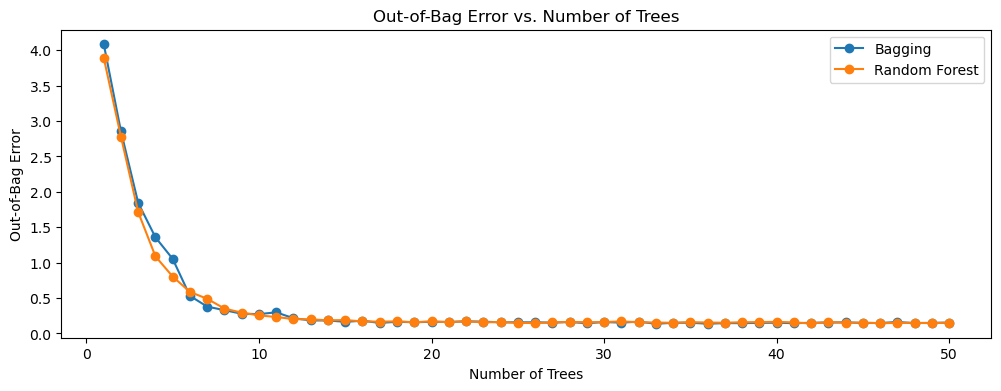

In [78]:
X = processed_house_data.drop('SalePrice', axis=1)
y = processed_house_data['SalePrice']

oob_errors_bagging = []
oob_errors_rf = []

tree_numbers = range(1, 51)

for n_trees in tree_numbers:
    bagging_model = BaggingRegressor(n_estimators=n_trees, oob_score=True)
    bagging_model.fit(X, y)
    oob_error_bagging = 1 - bagging_model.oob_score_
    oob_errors_bagging.append(oob_error_bagging)
    rf_model = RandomForestRegressor(n_estimators=n_trees, oob_score=True)
    rf_model.fit(X, y)
    oob_error_rf = 1 - rf_model.oob_score_
    oob_errors_rf.append(oob_error_rf)

plt.figure(figsize=(12, 4))
plt.plot(tree_numbers, oob_errors_bagging, label='Bagging', marker='o')
plt.plot(tree_numbers, oob_errors_rf, label='Random Forest', marker='o')
plt.xlabel('Number of Trees')
plt.ylabel('Out-of-Bag Error')
plt.title('Out-of-Bag Error vs. Number of Trees')
plt.legend()
plt.show()

BaggingRegressor is used with the number of trees specified by n_estimators.
oob_score=True indicates that out-of-bag (OOB) samples are used to estimate the R-squared score.

RandomForestRegressor is also used with the number of trees specified by n_estimators.
oob_score=True is set to enable out-of-bag error estimation.

tree_numbers represents the range of the number of trees you want to consider. The out-of-bag errors for both Bagging and Random Forest are calculated and plotted against the number of trees. The out-of-bag error is a useful metric for assessing the performance of the ensemble models.

As we can see from the plots typically, as the number of trees increases, the out-of-bag error tends to decrease. From the plot we can see that approximately $15$ trees are enough to do the prediction.

### _(k) Check computational times for both approaches. Why the random forest is typically faster and needs less trees? Check which approach is implemented in your software for variable importance. Compute these and compare to the results for lasso, single tree, and LR._

In [79]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

start_time = time.time()
bagging_model = BaggingRegressor(n_estimators=100, random_state=42)
bagging_model.fit(X_train, y_train)
bagging_pred = bagging_model.predict(X_test)
bagging_time = time.time() - start_time

# Random Forest
start_time = time.time()
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)
rf_time = time.time() - start_time

# Lasso
start_time = time.time()
lasso_model = Lasso(alpha=0.01, random_state=42)
lasso_model.fit(X_train, y_train)
lasso_pred = lasso_model.predict(X_test)
lasso_time = time.time() - start_time

# Decision Tree
start_time = time.time()
tree_model = DecisionTreeRegressor(random_state=42)
tree_model.fit(X_train, y_train)
tree_pred = tree_model.predict(X_test)
tree_time = time.time() - start_time

# Linear Regression
start_time = time.time()
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
lr_pred = lr_model.predict(X_test)
lr_time = time.time() - start_time

# Compute Mean Squared Error for each model
mse_bagging = mean_squared_error(y_test, bagging_pred)
mse_rf = mean_squared_error(y_test, rf_pred)
mse_lasso = mean_squared_error(y_test, lasso_pred)
mse_tree = mean_squared_error(y_test, tree_pred)
mse_lr = mean_squared_error(y_test, lr_pred)

# Print results
print("Mean Squared Error:")
print("Bagging:", mse_bagging)
print("Random Forest:", mse_rf)
print("Lasso:", mse_lasso)
print("Decision Tree:", mse_tree)
print("Linear Regression:", mse_lr)

# Print computational times
print("\nComputational Times:")
print("Bagging Time:", bagging_time)
print("Random Forest Time:", rf_time)
print("Lasso Time:", lasso_time)
print("Single Tree Time:", tree_time)
print("Linear Regression Time:", lr_time)

Mean Squared Error:
Bagging: 1210355361.7660248
Random Forest: 1237764099.501202
Lasso: 2446546864.6140294
Decision Tree: 2046028662.0035336
Linear Regression: 2446543936.6434426

Computational Times:
Bagging Time: 1.0420148372650146
Random Forest Time: 1.0000929832458496
Lasso Time: 0.09606575965881348
Single Tree Time: 0.02027606964111328
Linear Regression Time: 0.0065729618072509766


Here we can see that random forest is typically faster and need less trees as it is an extension of bagging, but creates more “uncorrelated” trees. As a result we get much more heterogenious and more independent trees. In each tree node we restrict the choice of features for splitting to a random subset of available features.

In sklearn library in Python the importance of a feature is computed as the (normalized) total reduction of the criterion (Gini impurity for classification or mean squared error for regression) brought by that feature.

As we can see Lasso and Linear Regression provided similar MSE. MSE provided by Decision Tree is a little bit less than LR and Lasso. Moreover, bagging and random forest provides MSE, which is less in a half. Random forest provides the best preformance.

# Problem 7: Classification
## Next we consider classify the houses by defining
## $$Y_i = \begin{cases} 1, \text{if SalePrice} > 130000 \\ 0, \text{else} \end{cases}$$
## The aim is classify houses to these two classes.

## _1. Estimate the logistic regression using a backward model selection with AIC as the selection criterion. To speed up the computation consider only numeric features in the initial model. Further work only with the final model._

In [80]:
def aic_score(estimator, X, y):
    k = X.shape[1] + 1 if estimator.fit_intercept else X.shape[1]
    n = len(y)
    y_pred = estimator.predict(X)
    sigma_squared = (y - y_pred).T @ (y - y_pred) / (n - k - 1)
    aic_score = np.log(sigma_squared) + 2 * k /n
    return aic_score

eps = 1e-6
sfs = SequentialFeatureSelector(LogisticRegression(), scoring=aic_score, direction='backward', tol=eps)

processed_numeric_house_data = house_data.dropna(axis='columns', thresh=house_data.shape[0] - 50).dropna().select_dtypes(include = ['float64', 'int64']).drop(columns=['MSSubClass'])
X = processed_numeric_house_data.copy()
X['SalePrice_binary'] = (X['SalePrice'] > 130000).astype('int')
y = X['SalePrice_binary']
X = X.drop(columns=['SalePrice', 'SalePrice_binary'])

sfs = sfs.fit(X, y)
optimal_numeric_selection = X.loc[:, sfs.get_support()]

print(f"Selected {len(optimal_numeric_selection.columns)} parameters ({list(optimal_numeric_selection.columns)})")

Selected 28 parameters (['LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF2', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold'])


## _2. Explain why we cannot use MSE or similar objective function when we estimate the logistic regression._

The Mean Squared Error (MSE) or similar objective functions are not suitable for logistic regression, because the response variable in logistic regression is binary ($0$ or $1$), representing the outcome of a binary event.

MSE is designed to measure the average squared difference between predicted and actual values and it works okay for continious target variable. However, logistic regression models the probability of a binary outcome. Using MSE in this context may lead to biased and inefficient parameter estimates because it doesn't account for the specific distribution of the response variable.

Logistic function introduces non-linearity, and the relationship between the predictors and the log-odds of the event is not linear. MSE assumes a linear relationship, and applying it to a non-linear model like logistic regression also can result in biased and inconsistent parameter estimates.

MSE also assumes that the errors are normally distributed and homoscedastic (constant variance). However, in logistic regression, the errors are not normally distributed, and the variance is not constant across all levels of predictors. Using MSE would violate these assumptions and lead to inappropriate inference.

## _3. Consider the explanatory variable LotArea. Obviously its parameter cannot be interpreted in the same way as for a linear regression. Provide the correct interpretation using the estimated parameter and using odds._

Let's find the estimation of the parameter, corresponding to 'LotArea' ($\beta$) and its odd ($e^{\beta}$):

In [81]:
X = np.array(optimal_numeric_selection['LotArea']).reshape(-1, 1)

logr_model_lot_area = LogisticRegression().fit(X, y)
beta = logr_model_lot_area.coef_
odd = np.exp(beta)

beta, odd

(array([[0.00013395]]), array([[1.00013396]]))

As it is positive, then the probability that $'SalePrice' > 130000$ increases with increasing of 'LotArea'. But given the odd value we can see that the probability of $'SalePrice' > 130000$ is greater than the probability of $'SalePrice' \leq 130000$ by $1.00013396$. So, actually these probabilities are almost the same. Thus, value of 'LotArea' doesn't have a significant impact on the value of 'SalePrice'.

## _4. Select several variables that increase the probability of $Y = 1$ and several variables that decrease this probability? Is this consistent with economic intuition?_

In [82]:
X = np.array(optimal_numeric_selection)
y = np.array((processed_numeric_house_data['SalePrice'] > 130000).astype('int')).reshape(-1, 1)

logr_model = LogisticRegression().fit(X, y)
beta = logr_model.coef_
print(f"Variables, that increase the probability of Y = 1 are: {list(optimal_numeric_selection.columns[beta[0] > 0])}")
print(f"\nVariables, that decrease the probability of Y = 1 are: {list(optimal_numeric_selection.columns[beta[0] < 0])}")

Variables, that increase the probability of Y = 1 are: ['LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'MasVnrArea', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'Fireplaces', 'GarageCars', 'WoodDeckSF', 'OpenPorchSF', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal']

Variables, that decrease the probability of Y = 1 are: ['YearRemodAdd', 'BsmtFinSF2', 'LowQualFinSF', 'GrLivArea', 'KitchenAbvGr', 'TotRmsAbvGrd', 'EnclosedPorch', 'MoSold']


Most of features that increases the probability of Y = 1 are consistent with economic intuition. If we look at those, that decrease, we can notice that areas above grade ('GrLivArea', 'KitchenAbvGr', 'TotRmsAbvGrd') decrease the probability of Y = 1. It's a little bit confusing from the economic intuition perspectives.

## _5. Randomly pick up five houses. Determine their probabilities of having a price above $130000$. Provide for the first of them the formula for the probability with inserted values of the parameters and variables. If you want to predict the membership in one of the two groups for a particular house, what is the simplest way to proceed using these probabilities?_

To determine probabilities of $Y_i=1$ for observation $X_i$ given estimated parameters $\hat\beta_j$ is:
$$P(\hat{Y_i = 1|X_i}) = \frac{1}{1 + e^{-\hat\beta_0 - \hat\beta_1X_{1i} - \hat\beta_2X_{2i} - \dots -\hat\beta_kX_{ki}}}$$
Given $P(\hat{Y_i = 1|X_i})$ we can predict the membership of the observation in a group by choosing a threshold. Typically it's $0.5$.

Let's choose random $5$ houses:

In [83]:
random_houses = optimal_numeric_selection.loc[np.random.RandomState(42).randint(0, len(y), 5)]
random_houses

,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF2,TotalBsmtSF,1stFlrSF,2ndFlrSF,...,Fireplaces,GarageCars,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold
Id,,,,,,,,,,,,,,,,,,,,,
1126,10434,4,5,1955,1955,0.0,0,1005,1005,0,...,1,2,0,0,0,0,0,0,0,11
860,11029,6,7,1968,1984,220.0,0,1054,1512,1142,...,1,2,0,65,0,0,222,0,0,8
1294,10140,7,5,1976,1976,0.0,0,832,832,832,...,1,2,0,28,0,0,259,0,0,3
1130,7200,5,5,1980,1980,180.0,0,936,936,0,...,0,2,49,0,0,0,0,0,0,8
1095,5868,5,7,1956,2000,0.0,240,936,936,0,...,0,1,0,0,80,0,160,0,0,5


Then let's find probabilities $P(\hat{Y_i = 1|X_i})$ for each observation:

In [84]:
logr_model.predict_proba(random_houses).T[1]

array([0.50204656, 0.99959953, 0.97754888, 0.51445909, 0.39214448])

So, given threshold $0.5$ we predict that all the observations except of the last one will have $'SalePrice' > 130000$.

## _6. Compute the classification table (confusion matrix) and calculate the specificity and sensitivity. Provide verbal interpretation for the elements of the classification table and the performance measures (specificity, sensitivity, accuracy)._


First compute confusion matrix:

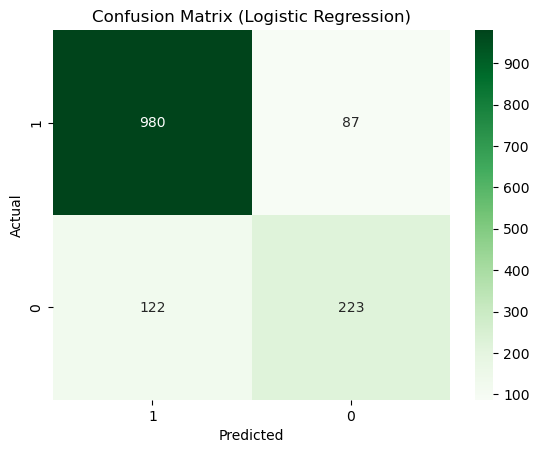

In [85]:
y_pred = logr_model.predict(X)
conf_mat = confusion_matrix(y, y_pred, labels=[1,0])
sns.heatmap(conf_mat, annot=True, cmap="Greens", fmt="g", xticklabels=[1,0], yticklabels=[1,0])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Logistic Regression)')
plt.show()

So, here we have:

True Positive (TP) (in our case - $980$) - the number of instances correctly predicted as positive.

True Negative (TN) (in our case - $223$) - The number of instances correctly predicted as negative.

False Positive (FP) (in our case - $87$) - The number of instances incorrectly predicted as positive (the actual class was negative) (Type I error).

False Negative (FN) (in our case - $122$) - Definition: The number of instances incorrectly predicted as negative (the actual class was positive) (Type II error).


Then calculate sensitivity, specificity and accuracy of the model based on the elements of the confusion matrix:
$$Accuracy = \frac{TP + TN}{TP + TN + FP + FN}$$
$$Sensitivity = \frac{TP}{TP + FN}$$
$$Specificity = \frac{TN}{TN + FP}$$

In [86]:
tp, fp, fn, tn = conf_mat.ravel()
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)
accuracy = (tp + tn) / (tp + tn + fp + fn)
sensitivity, specificity, accuracy

(0.8892921960072595, 0.7193548387096774, 0.8519830028328612)

Accuracy is the overall correctness of the model's predictions. A higher accuracy indicates a better-performing model.

Sensitivity measures the ability of the model to correctly identify positive instances. A higher sensitivity indicates that the model is good at capturing positive cases.

Specificity measures the ability of the model to correctly identify negative instances. A higher specificity indicates that the model is good at avoiding false alarms for negative cases.

So, based on these measures we can say, that $85\%$ of predictions are correct on average. Moreover, our model predicts positive instances with probability $88\%$ and negative ones with probability $71\%$.

## _7. It makes sense to change the threshold used for classification to improve the performance. This can be done using the ROC curve. Plot this curve and determine the optimal threshold. Explain the idea of the curve and of the AUC measure. Which shape of the ROC curve do we prefer and how exactly do we determine the optimal threshold?_

ROC-curve is a graphical representation that illustrates the performance of a binary classification model across various threshold values. It plots the True Positive Rate against the False Positive Rate at different threshold settings.

A diagonal line ($45$-degree line) represents a random classifier with no discriminatory power.

Points above the diagonal line indicate better-than-random classification.

For measuring how good is a classification model we can use AUC values. It measures the area under the ROC curve. It provides a single scalar value summarizing the classifier's performance across all possible thresholds. It ranges from $0$ to $1$, where $0.5$ indicates a random classifier, and 1 indicates a perfect classifier. Higher AUC values suggest better overall model performance.

Thus, ideally, we prefer an ROC-curve that bends towards the upper-left corner, indicating higher sensitivity and specificity. In such case AUC will be equal to $1$.

The closer the ROC curve is to the upper-left corner, the better the model's ability to discriminate between the two classes.

The optimal threshold depends on the balance between sensitivity and specificity. The point on the ROC curve closest to the upper-left corner $(0, 1)$ is often considered as an optimal operating point.

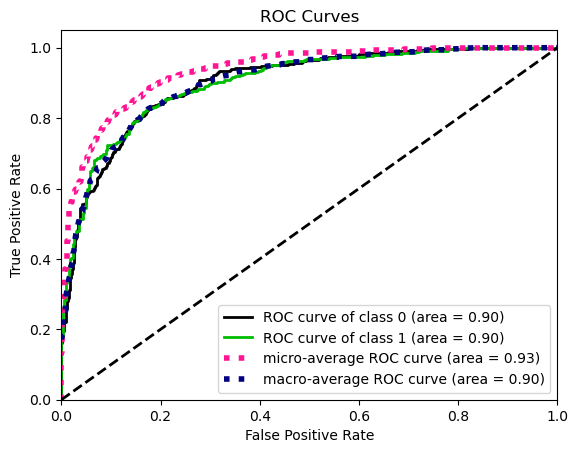

In [87]:
probabilities = logr_model.predict_proba(X)

plot_roc(y, probabilities)
plt.show()

Given this plot, we can identify the closest point to the upper-left corner. It's approximately $(0.1, 0.8)$

In [88]:
fpr, tpr, thresholds = roc_curve(y, probabilities[:,1])
roc_auc = auc(fpr, tpr)
optimal_threshold = thresholds[np.argmax(tpr - fpr)]
roc_auc, optimal_threshold

(0.9014628580742431, 0.7209588108379135)

As AUC is $0.90$, which is close to $1$, then our model provides a good performance. The optimal threshold is $0.72$.

## _8. Recompute the classification table, sensitivity and specificity for the new threshold. Provide interpretation of the obtained values. Compare the results with the original values. Is the procedure now more conservative or less conservative?_

In [89]:
y_pred_new = probabilities[:,1] > optimal_threshold

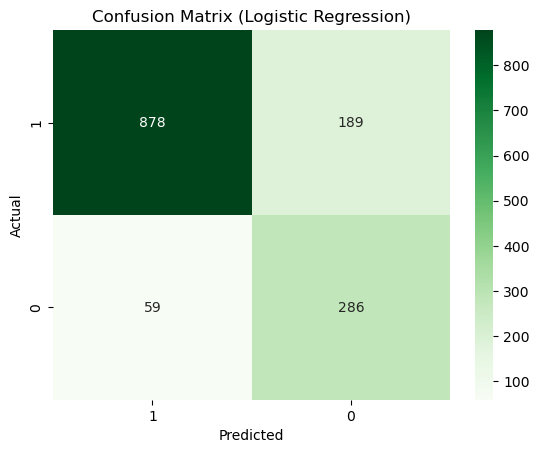

In [90]:
conf_mat = confusion_matrix(y, y_pred_new, labels=[1,0])
sns.heatmap(conf_mat, annot=True, cmap="Greens", fmt="g", xticklabels=[1,0], yticklabels=[1,0])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Logistic Regression)')
plt.show()

We can notice that confusion matrix has been changed. Now we have more type I errors that previously. Also here we can see that the number of correctly classified as '1' observation decreased a little bit, as well as the number of correctly classified as '0' observation increased.

In [91]:
tp, fp, fn, tn = conf_mat.ravel()
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)
accuracy = (tp + tn) / (tp + tn + fp + fn)
sensitivity, specificity, accuracy

(0.9370330843116329, 0.6021052631578947, 0.8243626062322946)

We can see that accuracy approximately is the same as previously, but sensitivity and specificity significantly changed.

## _9. Next we consider three classes_
## $$Y_i = \begin{cases} 2, \text{if} SalePrice > 20000 \\ 1, \text{if 20000} \geq SalePrice > 13000 \\ 0, \text{if 13000} \geq SalePrice \end{cases}$$
## _Train a single classification tree with 10 splits. Explain the objective function used in your software. Plot the tree, select a single terminal node and explain all the values shown there. Relate these to the concepts discussed in the lectures. Check the accuracy, provide and discuss the confusion matrix._

In [92]:
def encode(x):
    if x > 200000:
        return 2
    elif x > 130000:
        return 1
    else:
        return 0

X = processed_numeric_house_data.copy()
X['SalePrice_encoded'] = X.apply(lambda x: encode(x['SalePrice']), axis=1)
y = X['SalePrice_encoded']
X = X.drop(columns=['SalePrice', 'SalePrice_encoded'])

sfs = sfs.fit(X, y)
optimal_numeric_selection = X.loc[:, sfs.get_support()]

print(f"Selected {len(optimal_numeric_selection.columns)} parameters ({list(optimal_numeric_selection.columns)})")

Selected 30 parameters (['LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold'])


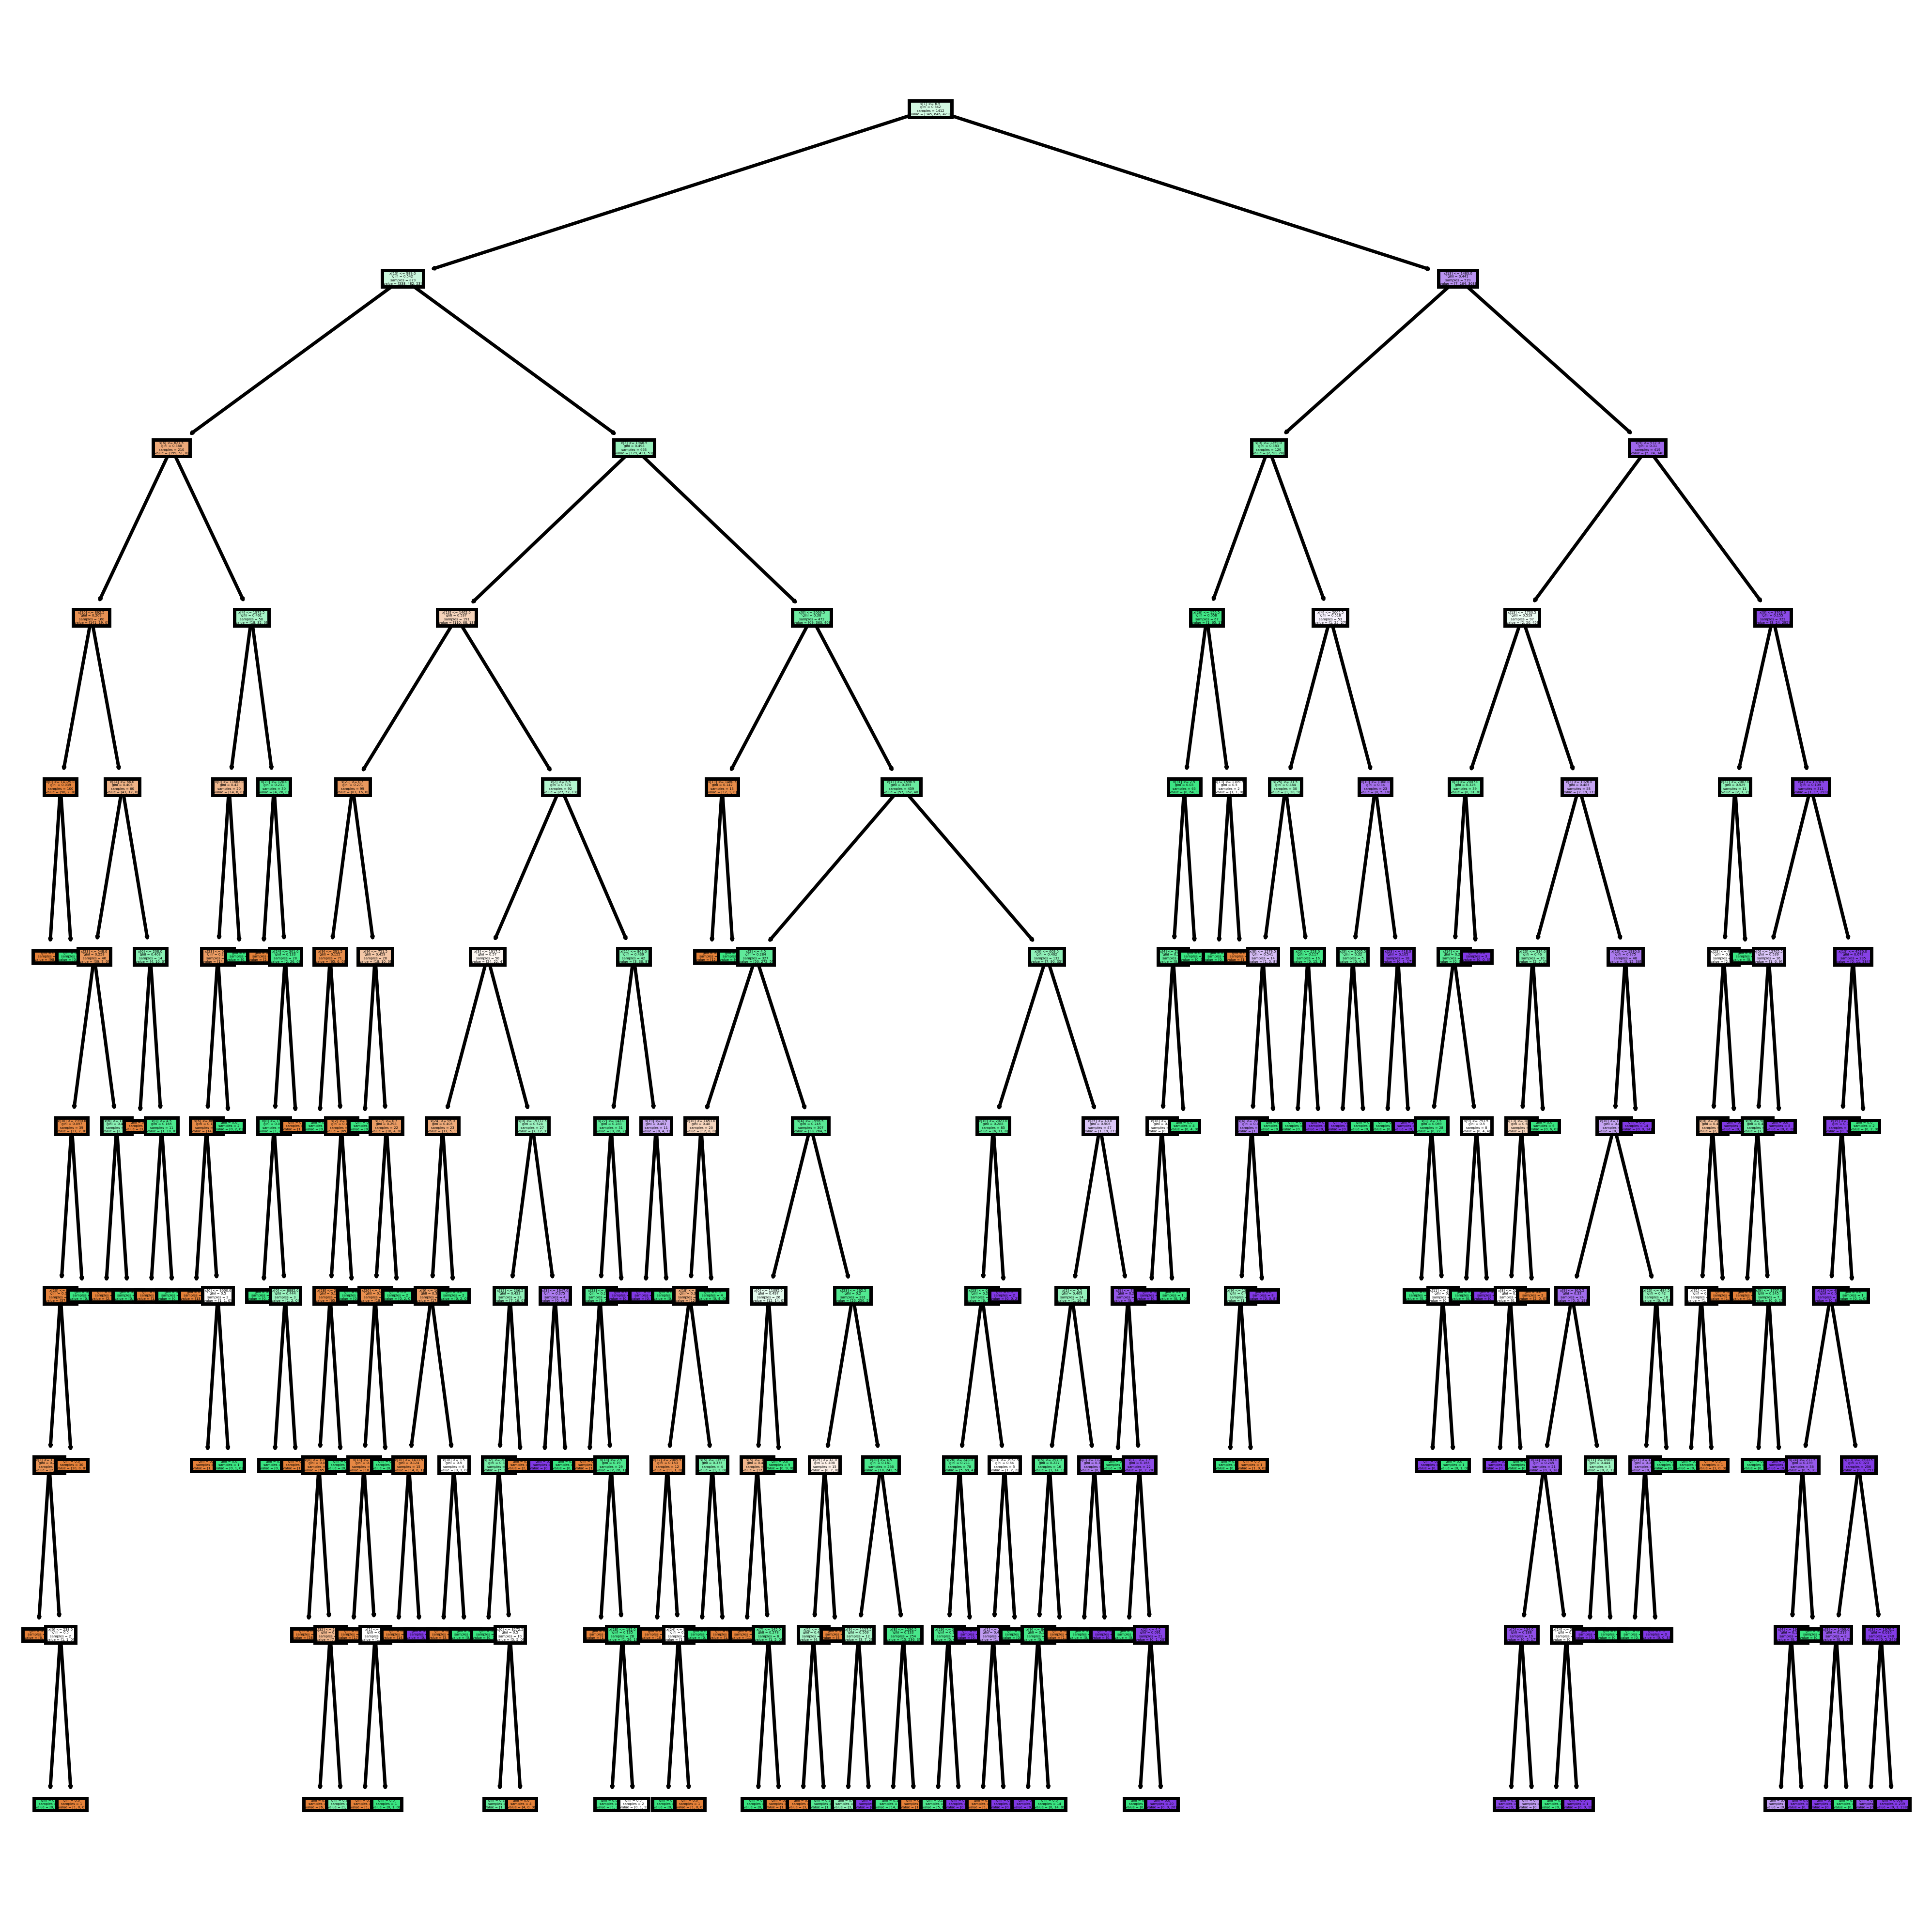

In [93]:
tree_classifier = DecisionTreeClassifier(max_depth=10, random_state=42)
tree_classifier.fit(X, y)

fig, axes = plt.subplots(figsize = (10,10), dpi=500)
plot_tree(tree_classifier, filled=True)
plt.show()

Here is a screen of the first left node from the root.

![caption](tree_node.png)

So, the first line indicates splitting criterion (Feature ($x[13]$) and Threshold ($989.0$)). Let's find, which feature does it correspond:

In [94]:
X.columns[13]

'GrLivArea'

So, the criterion is $'GrLivArea' \leq 989.0$. It describes the condition for branching to child nodes. So, it means that observations $'GrLivArea' \leq 989.0$ will follow the left branch, and those with $'GrLivArea' > 989.0$ will follow the right branch.

Gini - a measure of impurity in the node's class distribution. A lower gini impurity indicates a more pure node, where instances predominantly belong to a single class.

Samples - indicates the size of the dataset that satisfies the conditions leading to this specific node.

Value - a list, where each value shows how many instances of the corresponding class reached the node. The class with the highest count is often considered the predicted class for the node.

Let $R_m$ with $m = 1, \dots, m$ be the terminal nodes with $N_m$ observations.

Then, $\hat p_{mk} = \frac{1}{N_m}\sum\limits_{i \in R_m} I(y_i = k)$ is the proportion of class $k$ observation in node $m$.

We classify an observation falling into node $R_m$ to class $k(m)$ such that:
$$k(m) = \arg\max_k \hat p_{km}$$

An objective function of a classification tree is:
$$\sum\limits_{m=1}^{|T|}N_mQ_m(T) + \alpha|T| \rightarrow min$$
where $Q_m(T)$ - is impurity measure, in our case - gini index:
$$Gini_m = \sum\limits_{k \neq k'}\hat p_{mk} \hat p_{mk'} = \sum\limits_{k=1}^K \hat p_{mk}(1 - \hat p_{mk})$$

In [95]:
y_pred = tree_classifier.predict(X)
accuracy = accuracy_score(y, y_pred)
accuracy

0.9730878186968839

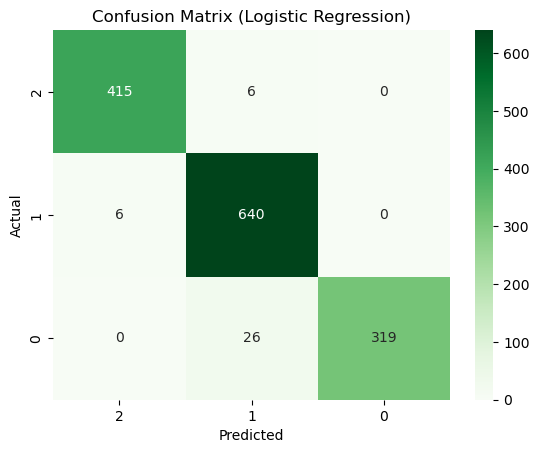

In [96]:
conf_mat = confusion_matrix(y, y_pred, labels=[2,1,0])
sns.heatmap(conf_mat, annot=True, cmap="Greens", fmt="g", xticklabels=[2,1,0], yticklabels=[2,1,0])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Logistic Regression)')
plt.show()

So, according to accuracy score do the $97\%$ of predictions correctly.

Looking at the confusion matrix, we can see that most of the classes are classified correctly, there are $6$ observations, where classes '2' and '1' were confused, and $26$ observations of true '0' classes, where recognized as '1'.